## Setup

In [1]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import ast

import numpy as np
import pandas as pd
import random
import isuelogit as isl
import glob
import time

from sklearn import preprocessing
from sklearn.impute import SimpleImputer

import geopandas as gpd
import contextily as ctx

In [2]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [3]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

sys.path.append(os.path.join(main_dir, 'src'))

isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/github/nesuelogit


In [4]:
%load_ext autoreload
%autoreload 2

from pesuelogit.networks import read_OD
from pesuelogit.etl import data_curation, add_period_id

# Internal modules
from nesuelogit.models import NESUELOGIT, ODParameters, UtilityParameters, BPR, MLP, KernelConstraint, \
    GenerationParameters, train_kfold, compute_generated_trips, compute_generation_factors, \
    compute_benchmark_metrics, PolynomialLayer, compute_baseline_predictions_kfold
from nesuelogit.etl import build_network, get_tensors_by_year
from nesuelogit.visualizations import  plot_predictive_performance, plot_metrics_kfold, plot_top_od_flows_periods, \
    plot_utility_parameters_periods, plot_rr_by_period, plot_rr_by_period_models, plot_total_trips_models, \
    plot_performance_functions, plot_flow_vs_traveltime, plot_flow_interaction_matrix, plot_parameters_kfold, \
    plot_convergence_estimates, plot_parameters, plot_baselines_kfold,  plot_congestion_maps
from nesuelogit.metrics import mse, btcg_mse, mnrmse, mape, nrmse, r2_score, zscore, z2score
from nesuelogit.utils import read_paths

In [5]:
# Seed for reproducibility
_SEED = 2023
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

In [6]:
# To report global runtime
t0_global = time.time()

In [7]:
# Set timestamp to add in the filenames that are written in disk
ts = datetime.now().strftime('%y%m%d%H%M%S')
print('Timestamp:',ts)

Timestamp: 231203234522


## Read nodes and link-specific data

In [8]:
nodes_df = pd.read_csv('./input/network-data/fresno/nodes/fresno-nodes-gis-data.csv')

links_df = pd.read_csv('./input/network-data/fresno/links/fresno-link-specific-data.csv',
                       converters={"link_key": ast.literal_eval, "pems_id": ast.literal_eval})

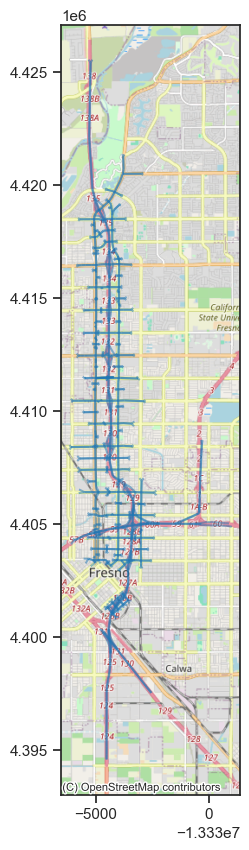

In [9]:
## Display network
links_gdf = gpd.read_file('./input/network-data/fresno/gis/links/fresno-links-gis.shp').set_crs(
        'EPSG:2228')
ax = links_gdf.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.5)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

## Build Fresno network

In [10]:
network = build_network(links_df=links_df, nodes_df=nodes_df, crs='epsg:4326', key= 'fresno')

## Read OD matrix

In [11]:
read_OD(network=network, sparse=True)

q_historic = np.repeat(network.q.flatten()[np.newaxis, :], 6, axis=0)

Matrix Q (1789, 1789) read in 0.0[s] with sparse format
66266.3 trips were loaded among 6970 o-d pairs



## Read paths

In [12]:
read_paths(network=network, update_incidence_matrices=True, filename = 'paths-full-model-fresno.csv')

Paths were read and incidence matrix were built


## Read spatiotemporal data

In [13]:
folderpath = './input/network-data/fresno/links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*link-data*")], axis=0)

df['link_key'] = pd.Categorical(df['link_key'].apply(ast.literal_eval), list(network.links_dict.keys()))
df['period'] = pd.to_datetime(df['period']).dt.strftime('%Y-%m-%d-%H')

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
# Select data from Tuesday (1) to Thursday (3)
df = df[df['date'].dt.dayofweek.between(1, 3)]
# Select data from one day only
#df = df[df['date'] == "2019-10-02"]

In [14]:
# Add period id for timevarying estimation

period_feature = 'hour'

df = add_period_id(df, period_feature='hour')

period_keys = df[[period_feature,'period_id']].drop_duplicates().reset_index().drop('index',axis =1).sort_values('hour')
print(period_keys)

    hour  period_id
11     6          0
12     7          1
13     8          2
14     9          3
0     10          4
1     11          5
2     12          6
3     13          7
4     14          8
5     15          9
6     16         10
7     17         11
8     18         12
9     19         13
10    20         14


In [15]:
df.head()

link_key  observed  counts  capacity [veh]  tt_ff [min]  \
0     (0, 1621, 0)         0     NaN          1800.0        0.098   
1  (1239, 1630, 0)         0     NaN             inf        0.000   
2    (228, 192, 0)         1  1667.0          2400.0        0.110   
3  (1243, 1631, 0)         0     NaN             inf        0.000   
4  (1244, 1632, 0)         0     NaN             inf        0.000   

   speed_ff[mi/hr]      inrix_id  pems_ids link_type   id  ...  median_age  \
0               45  1.626616e+09        []     LWRLK    1  ...        31.1   
1            99999           NaN        []     DMDLK  565  ...         0.0   
2               65  1.626659e+09  [602350]     LWRLK  564  ...        16.6   
3            99999           NaN        []     DMDLK  563  ...         0.0   
4            99999           NaN        []     DMDLK  562  ...         0.0   

   incidents  bus_stops  intersections       date  hour  tf_inrix  year  \
0          0          0              1 2019-10-01    10     0.221  2019   
1          0          0              0 2019-10-01    10     0.000  2019   
2          0          0              0 2019-10-01    10     0.112  2019   
3          0          0              0 2019-10-01    10     0.000  2019   
4          0          0              0 2019-10-01    10     0.000  2019   

          period  period_id  
0  2019-10-01-10          4  
1  2019-10-01-10          4  
2  2019-10-01-10          4  
3  2019-10-01-10          4  
4  2019-10-01-10          4  

[5 rows x 43 columns]

In [16]:
# Units in miles per hour
df[['speed_ref_avg','speed_hist_avg','speed_max']].describe()

speed_ref_avg  speed_hist_avg     speed_max
count   1.013460e+06    1.009583e+06  1.013460e+06
mean    1.924470e+01    1.767589e+01  2.051278e+01
std     1.982261e+01    1.909664e+01  2.140424e+01
min     0.000000e+00    0.000000e+00  0.000000e+00
25%     0.000000e+00    0.000000e+00  0.000000e+00
50%     2.112700e+01    1.755400e+01  2.112700e+01
75%     2.796200e+01    2.547600e+01  3.106900e+01
max     6.772900e+01    7.891400e+01  8.388500e+01

In [17]:
df.columns

Index(['link_key', 'observed', 'counts', 'capacity [veh]', 'tt_ff [min]',
       'speed_ff[mi/hr]', 'inrix_id', 'pems_ids', 'link_type', 'id', 'rhoj',
       'lane', 'ff_speed', 'length', 'alpha', 'beta', 'tf', 'k', 'inrix_id.1',
       'speed_avg', 'speed_ref_avg', 'speed_hist_avg', 'tt_avg', 'speed_max',
       'speed_sd', 'speed_cv', 'speed_hist_sd', 'speed_ref_sd', 'tt_sd',
       'tt_var', 'tt_cv', 'road_closures', 'median_inc', 'median_age',
       'incidents', 'bus_stops', 'intersections', 'date', 'hour', 'tf_inrix',
       'year', 'period', 'period_id'],
      dtype='object')

## Data curation

In [18]:
df.loc[df['speed_ref_avg']<=0,'speed_ref_avg'] = float('nan')

df['tt_ff'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_ref_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_ref_avg == 0),'tt_ff'] = float('nan')

df['tt_avg'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_hist_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_hist_avg == 0),'tt_avg'] = float('nan')

tt_sd_adj = df.groupby(['period_id','link_key'])[['tt_avg']].std().reset_index().rename(columns = {'tt_avg': 'tt_sd_adj'})

df = df.merge(tt_sd_adj, on = ['period_id','link_key'])

df = data_curation(df)

df['tt_sd'] = df['tt_sd_adj']

In [19]:
# Units of travel time features are converted from hours to minutes
df['tt_sd'] = df['tt_sd']*60
df['tt_avg'] = df['tt_avg']*60
df['tt_ff'] = df['tt_ff']*60

In [20]:
df[['speed_ref_avg','speed_hist_avg', 'tt_ff', 'tt_avg','tt_sd_adj']].describe()

speed_ref_avg  speed_hist_avg         tt_ff         tt_avg  \
count  599370.000000    1.009583e+06  1.013460e+06  887813.000000   
mean       32.540388    1.767589e+01  2.038423e-01       0.219493   
std        15.223625    1.909664e+01  2.610045e-01       0.262030   
min         8.078000    0.000000e+00  0.000000e+00       0.000000   
25%        24.233000    0.000000e+00  0.000000e+00       0.000000   
50%        26.719000    1.755400e+01  1.497376e-01       0.167050   
75%        32.933000    2.547600e+01  2.792397e-01       0.312986   
max        67.729000    7.891400e+01  4.220601e+00       3.827439   

          tt_sd_adj  
count  1.013460e+06  
mean   3.022799e-04  
std    4.638521e-04  
min    0.000000e+00  
25%    0.000000e+00  
50%    1.856268e-04  
75%    4.248116e-04  
max    1.243267e-02

## Node data

In [21]:
nodes_df = nodes_df.rename(columns ={'pop_tract':'population','stops_tract': 'bus_stops','median_inc':'income'})

In [22]:
features_generation = ['population','income', 'bus_stops']

nodes_df = nodes_df[['key','type'] + features_generation]

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(nodes_df[features_generation])
nodes_df[features_generation] = imp_mean.transform(nodes_df[features_generation])

scaler = preprocessing.StandardScaler().fit(nodes_df[features_generation].values)
# scaler = preprocessing.MinMaxScaler().fit(nodes_df[features_generation].values)
nodes_df[features_generation] = scaler.transform(nodes_df[features_generation].values)

## Utility function

In [23]:
_FEATURES_Z = ['tt_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

## Data processing

In [24]:
n_links = len(network.links)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year
X, Y = {}, {}

In [25]:
df.query('year == 2019')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'tt_sd']].describe()

counts          tt_ff         tt_avg       tf_inrix  \
count  31624.000000  542925.000000  468303.000000  542925.000000   
mean    1761.140959       0.204903       0.221931       0.200169   
std      770.228931       0.262226       0.266852       0.228208   
min        1.000000       0.000000       0.000000       0.000000   
25%     1249.000000       0.000000       0.000000       0.000000   
50%     1686.000000       0.150455       0.168820       0.152000   
75%     2162.450000       0.282111       0.318261       0.280000   
max     4807.000000       4.220601       3.827439       2.302000   

               tt_sd  
count  542925.000000  
mean        0.018137  
std         0.027831  
min         0.000000  
25%         0.000000  
50%         0.011138  
75%         0.025489  
max         0.745960

In [26]:
df.query('year == 2020')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'tt_sd']].describe()

counts          tt_ff         tt_avg       tf_inrix  \
count  27472.000000  470535.000000  419510.000000  470535.000000   
mean    1605.127777       0.202618       0.216770       0.198494   
std      743.713869       0.259583       0.256512       0.226003   
min        6.000000       0.000000       0.000000       0.000000   
25%     1108.450000       0.000000       0.000000       0.000000   
50%     1528.900000       0.149437       0.165341       0.150000   
75%     1978.000000       0.274658       0.306717       0.273000   
max     4766.000000       4.220601       3.274444       2.113000   

               tt_sd  
count  470535.000000  
mean        0.018137  
std         0.027831  
min         0.000000  
25%         0.000000  
50%         0.011138  
75%         0.025489  
max         0.745960

In [27]:
# Set free flow travel times
tt_ff_links = df.groupby('link_key')['tt_ff'].min()
for link in network.links:
    network.links_dict[link.key].performance_function.tf = float(tt_ff_links[tt_ff_links.index==link.key].iloc[0])

In [28]:
# This correlation should be positive
df[['counts','tt_avg']].corr()

counts    tt_avg
counts  1.000000  0.055122
tt_avg  0.055122  1.000000

## EDA

In [29]:
# To check that there is a balanced amount of observations per date
obs_date = df.groupby('date')['hour'].count()

In [30]:
# Stats by date
df.groupby('date')[['speed_sd','speed_avg', 'counts']].mean().assign(total_obs = obs_date)

speed_sd  speed_avg       counts  total_obs
date                                                   
2019-10-01  1.731787  17.175187  1770.335035      36195
2019-10-02  1.760109  17.169768  1746.651824      36195
2019-10-03  1.754288  17.092304  1785.115209      36195
2019-10-08  1.847060  18.165569  1747.732955      36195
2019-10-09  1.917923  18.137042  1756.834846      36195
2019-10-10  1.830232  18.107925  1793.512340      36195
2019-10-15  1.831527  18.114384  1750.339155      36195
2019-10-16  1.823680  18.162625  1760.170975      36195
2019-10-17  1.832219  18.080860  1775.411385      36195
2019-10-22  1.837839  18.175561  1738.314834      36195
2019-10-23  1.864443  18.222690  1753.243283      36195
2019-10-24  1.848827  18.184814  1746.626881      36195
2019-10-29  1.868430  18.167171  1731.246241      36195
2019-10-30  1.816364  18.109232  1757.581055      36195
2019-10-31  1.882446  18.128430  1804.595108      36195
2020-10-01  1.290377  19.579215  1616.266052      36195
2020-10-06  1.365919  19.709670  1581.200095      36195
2020-10-07  1.327017  19.927088  1587.425957      36195
2020-10-08  1.344382  19.969943  1604.360618      36195
2020-10-13  1.311842  19.626350  1607.663262      36195
2020-10-14  1.300075  19.558364  1613.399054      36195
2020-10-15  1.331493  19.621633  1637.123641      36195
2020-10-20  1.353743  19.597736  1599.044113      36195
2020-10-21  1.325694  19.501768  1587.235083      36195
2020-10-22  1.334320  19.591921  1628.075697      36195
2020-10-27  1.309348  19.573460  1583.478061      36195
2020-10-28  1.324270  19.646064  1593.821986      36195
2020-10-29  1.336212  19.557279  1627.548269      36195

### Link attributes

In [31]:
df[_FEATURES_Z].describe()

tt_sd    median_inc     incidents     bus_stops  intersections
count  1.013460e+06  1.013460e+06  1.013460e+06  1.013460e+06   1.013460e+06
mean   1.813680e-02  2.621913e+01  7.441093e-01  1.500207e-01   8.765023e-01
std    2.783112e-02  2.135738e+01  3.193143e+00  4.411927e-01   1.319496e+00
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00
50%    1.113761e-02  2.482100e+01  0.000000e+00  0.000000e+00   0.000000e+00
75%    2.548870e-02  4.168100e+01  0.000000e+00  0.000000e+00   1.000000e+00
max    7.459602e-01  1.158930e+02  4.000000e+01  4.000000e+00   9.000000e+00

## Training and validation sets

In [32]:
_DTYPE = tf.float32

# Data between 4pm and 5pm to estimate LUE, ODLUE and ODLULPE models
X, Y = get_tensors_by_year(df[df.hour.isin([16])], features_Z = _FEATURES_Z,
                           links_keys=list(network.links_dict.keys()))

# Hourly data DURING morning and afternoon peak hour windows (6 hour intervals) to estimate TVODLULPE
XT, YT = get_tensors_by_year(df[df.hour.isin([6,7,8, 15,16,17])], features_Z = _FEATURES_Z,
                             links_keys=list(network.links_dict.keys()))

# Split in training and test sets
X_train, X_val, Y_train, Y_val = map(lambda x: tf.cast(x, dtype = _DTYPE), [X[2019], X[2020], Y[2019], Y[2020]])
XT_train, XT_val, YT_train, YT_val = map(lambda x: tf.cast(x, dtype = _DTYPE), [XT[2019], XT[2020], YT[2019], YT[2020]])

In [33]:
XT[2019]

<tf.Tensor: shape=(90, 2413, 6), dtype=float64, numpy=
array([[[ 0.0179, 93.828 ,  0.    ,  0.    ,  1.    ,  0.    ],
        [ 0.0244, 66.653 ,  2.    ,  0.    ,  0.    ,  0.    ],
        [ 0.0255, 66.653 ,  6.    ,  0.    ,  0.    ,  0.    ],
        ...,
        [ 0.0021, 30.543 ,  1.    ,  0.    ,  1.    ,  0.    ],
        [ 0.003 , 23.611 ,  6.    ,  0.    ,  2.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ]],

       [[ 0.0276, 93.828 ,  0.    ,  0.    ,  1.    ,  1.    ],
        [ 0.0222, 66.653 ,  2.    ,  0.    ,  0.    ,  1.    ],
        [ 0.0255, 66.653 ,  6.    ,  0.    ,  0.    ,  1.    ],
        ...,
        [ 0.0018, 30.543 ,  1.    ,  0.    ,  1.    ,  1.    ],
        [ 0.0025, 23.611 ,  6.    ,  0.    ,  2.    ,  1.    ],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ]],

       [[ 0.0199, 93.828 ,  0.    ,  0.    ,  1.    ,  2.    ],
        [ 0.0315, 66.653 ,  2.    ,  0.    ,  0.    ,  2.    ],
        [ 0.0255, 6

## Configuration

In [34]:
_LOSS_WEIGHTS ={'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}
_EQUILIBRIUM_STAGE = True
_ALTERNATING_OPTIMIZATION = False

_LR = {'learning': 1e-1, 'equilibrium': 1e-2}

_BATCH_SIZE = 1
_EPOCHS = {'learning': 30, 'equilibrium': 30}

_XTICKS_SPACING = 5
_EPOCHS_PRINT_INTERVAL = {'learning':1, 'equilibrium':1}

_RELATIVE_GAP = 5e-2

_LOSS_METRIC  = z2score

_OPTIMIZERS = {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
              'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
              }

## Models

In [35]:
train_results_dfs = {}
val_results_dfs = {}
models = {}

In [36]:
def create_mlp(network, homogenous = False, diagonal = False, adjacency_constraint = True, poly_order = 4,
               alpha_prior = 0.15, beta_prior = 4, pretrain = False, dtype =_DTYPE, link_specific = True):

    return MLP(n_links=len(network.links),
               free_flow_traveltimes=[link.bpr.tf for link in network.links],
               capacities=[link.bpr.k for link in network.links],
               kernel_constraint=KernelConstraint(
                   link_keys=[(link.key[0], link.key[1]) for link in network.links],
                   dtype=dtype,
                   capacities=[link.bpr.k for link in network.links],
                   adjacency_constraint=adjacency_constraint,
                   free_flow_traveltimes=[link.bpr.tf for link in network.links],
                   diagonal= diagonal,
                   homogenous=homogenous,
                   bounds_clipping = [0,10],
                   min_diagonal_value = 1e-1
               ),
               trainable =True,
               polynomial_layer= PolynomialLayer(poly_order=poly_order,
                                                 trainable = True,
                                                 pretrain_weights=pretrain,
                                                 alpha_prior = alpha_prior, beta_prior=beta_prior,
                                                 kernel_constraint=tf.keras.constraints.NonNeg(),
                                                 link_specific = link_specific
                                                 ),
               alpha_relu = 0,
               depth=1,
               max_traveltime_factor = None,
               dtype=dtype)

def create_bpr(network, alpha_prior = 1, beta_prior = 1, dtype =_DTYPE):
    return BPR(keys=['alpha', 'beta'],
               initial_values={'alpha': alpha_prior * tf.ones(len(network.links), dtype = dtype),
                               'beta': beta_prior * tf.ones(len(network.links), dtype = dtype)},
               true_values={'alpha': 0.15, 'beta': 4},
               trainables={'alpha': True, 'beta':True},
               capacities = [link.bpr.k for link in network.links],
               free_flow_traveltimes =[link.bpr.tf for link in network.links],
               dtype = dtype
               )

def create_model(network, model_key = 'tvgodlulpe', dtype=_DTYPE, n_periods=1, features_Z=_FEATURES_Z, historic_g=None,
                                      performance_function=None, utility_parameters = None, od_parameters = None,
                                      generation_parameters = None, generation = True, od_trainable = False,
                                      utility_trainable = True, pretrain_generation_weights = True, generation_trainable = True):

    if utility_parameters is None:
        utility_parameters = UtilityParameters(features_Y=['tt'],
                                               features_Z=features_Z,
                                               initial_values={
                                                   'tt': -3.0597,
                                                   'tt_sd': -3.2678, 'median_inc': 0,
                                                   'incidents': -4.5368, 'bus_stops': 0, 'intersections': -3.8788,
                                                   'psc_factor': 0,
                                                   'fixed_effect': np.zeros_like(network.links)},

                                               signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                      'bus_stops': '-', 'intersections': '-'},
                                               trainables={'psc_factor': False, 'fixed_effect': utility_trainable,
                                                           'tt': utility_trainable, 'tt_sd': True, 'median_inc': True,
                                                           'incidents': True,
                                                           'bus_stops': True, 'intersections': True
                                                           },
                                               time_varying=True,
                                               dtype=dtype
                                               )

    if performance_function is None:
        # performance_function = create_bpr(network = network, dtype = dtype)
        performance_function = create_mlp(network = network, dtype = dtype)

    if generation_parameters is None and generation:
        generation_parameters = GenerationParameters(
            features_Z=['population', 'income', 'bus_stops'],
            keys=['fixed_effect_od', 'fixed_effect_origin', 'fixed_effect_destination'],
            initial_values={'income': 0, 'population': 0, 'bus_stops': 0,
                            # 'fixed_effect': historic_g[0]
                            'fixed_effect': historic_g
                            },
            signs={'income': '+', 'population': '+', 'bus_stops': '-'},
            trainables={'fixed_effect': generation_trainable,
                        'income': False, 'population': False, 'bus_stops': False,
                        # 'income': True, 'population': True, 'bus_stops': True,
                        'fixed_effect_origin': False, 'fixed_effect_destination': False, 'fixed_effect_od': generation_trainable
                        },
            time_varying=True,
            historic_g= historic_g,
            pretrain_generation_weights=pretrain_generation_weights,
            dtype=dtype
        )

    if od_parameters is None:
        od_parameters = ODParameters(key='od',
                                     initial_values= q_historic,
                                     historic_values={10: network.q.flatten()},
                                     ods=network.ods,
                                     n_nodes = len(network.nodes),
                                     n_periods=n_periods,
                                     time_varying=True,
                                     trainable= od_trainable
                                     )

    model = NESUELOGIT(
        key=model_key,
        network=network,
        dtype=dtype,
        utility=utility_parameters,
        performance_function=performance_function,
        od=od_parameters,
        generation=generation_parameters,
        n_periods=n_periods
    )

    return model, {'utility_parameters': utility_parameters, 'generation_parameters': generation_parameters,
                   'od_parameters': od_parameters, 'performance_function': performance_function}

In [37]:
# Total trips tvodlulpe pesuelogit:
# Epoch 0: 6.6e+04 6.6e+04 6.6e+04 6.6e+04 6.6e+04 6.6e+04
# Final epoch: 6.4e+04 6.6e+04 6.3e+04 7.8e+04 7.9e+04 7.9e+04
# Growth factor captures the difference between the reference OD at epoch 0 and the estimated OD.
growth_factor = 7.9/6.6
#growth_factor = 1

generation_factors = compute_generation_factors(period_column=XT_train[:, :, -1, None].numpy(),
                                                              flow_column=YT_train[:,:,1, None].numpy(), reference_period=10)

n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

generated_trips = growth_factor*generation_factors.values[:,np.newaxis]*compute_generated_trips(
    q = q_historic, ods= network.ods, n_nodes = len(network.nodes))

### Benchmark (TVODLULPE)

In [38]:

# To report runtime
t0 = time.time()

models['tvodlulpe'], _ = create_model(
    model_key = 'tvodlulpe',
    n_periods= n_periods, network = network,
    performance_function = create_bpr(network = network, dtype = _DTYPE, alpha_prior = 0.9327, beta_prior = 4.1017),
    od_parameters = ODParameters(key='od',
                                 #initial_values= generation_factors.values[:,np.newaxis]*tntp_network.q.flatten(),
                                 initial_values = tf.stack(q_historic),
                                 historic_values={10: q_historic[0].flatten()},
                                 ods=network.ods,
                                 n_nodes = len(network.nodes),
                                 n_periods=n_periods,
                                 time_varying=True,
                                 trainable=True),
    generation = False,
    utility_trainable = True
)

models['tvodlulpe'].key = 'tvodlulpe'

In [39]:
train_results_dfs['tvodlulpe'], val_results_dfs['tvodlulpe'] = models['tvodlulpe'].fit(
    XT_train, YT_train, XT_val, YT_val,
    optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
                 'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])},
    node_data=nodes_df,
    batch_size=_BATCH_SIZE,
    loss_weights=_LOSS_WEIGHTS,
    loss_metric= _LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    alternating_optimization=_ALTERNATING_OPTIMIZATION,
    pretrain_link_flows = True,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
    epochs=_EPOCHS)

print(f'runtime: {time.time()-t0:0.1f} [s]')

# Save model weights for prediction analyses
models['tvodlulpe'].save_weights(models['tvodlulpe']._filepath_weights)
print(f"\nModel weights were saved at '{models['tvodlulpe']._filepath_weights}'")


Model training

Link flows and travel times were pretrained with single pass of traffic assignment
Benchmark metrics using historical mean in training data to make predictions in the validation set: 


    component    value metric
0        flow       57   mape
1  traveltime       55   mape
0        flow    6e+05    mse
1  traveltime    0.063    mse
0        flow   -0.057     r2
1  traveltime -0.00022     r2

hyperparameters loss function: {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

number of periods: 6, batch size: 1, threshold relative gap: 0.05
training set -> timepoints: 90, obs [t x]: [2073.  140.], coverage [t x]: [0.86 0.06]
validation set -> timepoints: 78, obs [t x]: [2139.  140.], coverage [t x]: [0.89 0.06]

Learning stage: 30 epochs

0/60: train mse=6.2e+05, train mse traveltime=1.3, train mape traveltime=121.8 train mse flow=1.7e+06, train mape flow=97.8, val mse=7.4e+05, val mse traveltime=1.3, val mape traveltime=122.3 val mse flow=1.9e+06, val mape flow=93

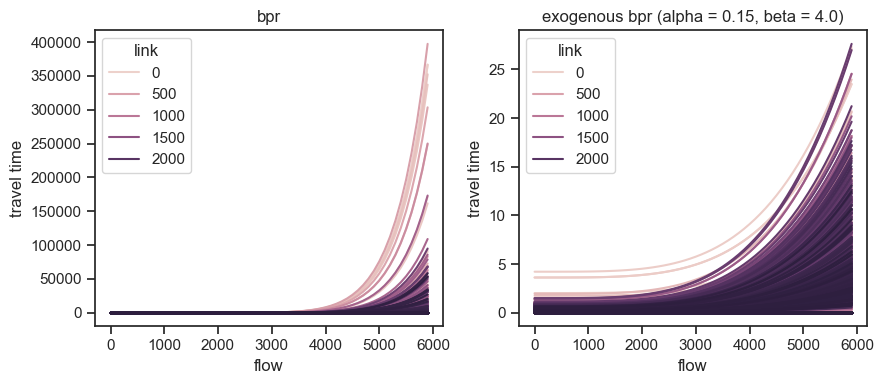

In [40]:
flow_range = range(0,6000,100)
sharey = False

fig, axs = plot_performance_functions(model = models['tvodlulpe'],
                                      network = network,
                                      marginal = False,
                                      #alpha=models['tvodlulpe'].performance_function.alpha,
                                      #beta=models['tvodlulpe'].performance_function.beta,
                                      alpha=0.15*np.ones(network.get_n_links()),
                                      beta=4*np.ones(network.get_n_links()),
                                      sharey = sharey,
                                      flow_range = flow_range
                                      # selected_links = np.random.choice(range(tntp_network.get_n_links()), 10, replace=False)
                                      )

# for ax in axs.reshape(-1):
#     ax.set_xlim(xmin=-10)
#     ax.set_ylim(ymin=-1)
#     ax.legend(loc='upper left', title = 'link')

plt.savefig('output/figures/results/fresno-comparison-all-link-performance-functions-tvodlulpe.png')

plt.show()

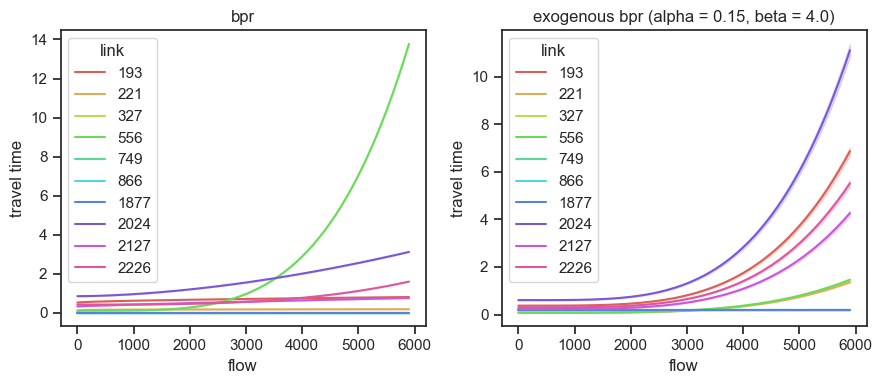

In [41]:
selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)

plot_performance_functions(model=models['tvodlulpe'],
                           network=network,
                           marginal=True,
                           # alpha=models['tvodlulpe'].performance_function.alpha,
                           # beta=models['tvodlulpe'].performance_function.beta,
                           alpha=0.15*np.ones(network.get_n_links()),
                           beta=4*np.ones(network.get_n_links()),
                           selected_links = selected_links,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.show()

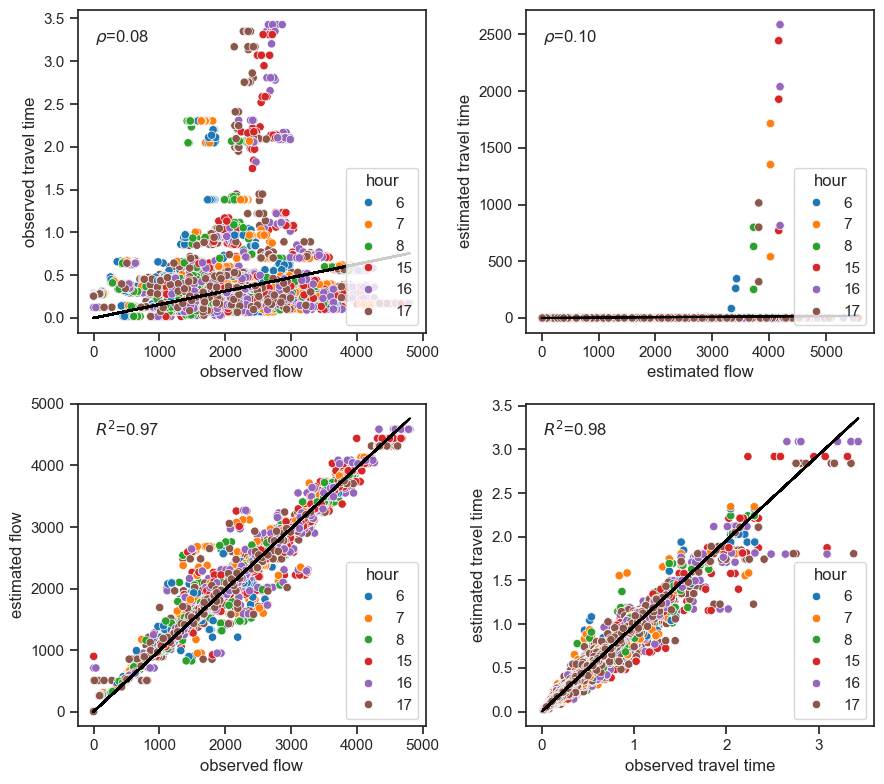

In [42]:
fig, axs = plot_flow_vs_traveltime(model = models['tvodlulpe'],
                        observed_traveltime=models['tvodlulpe'].mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= models['tvodlulpe'].mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.show()

(<Figure size 550x500 with 1 Axes>, <Axes: xlabel='epoch', ylabel='mape (%)'>)

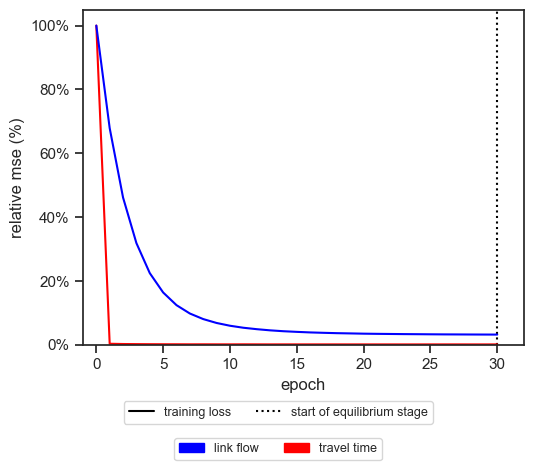

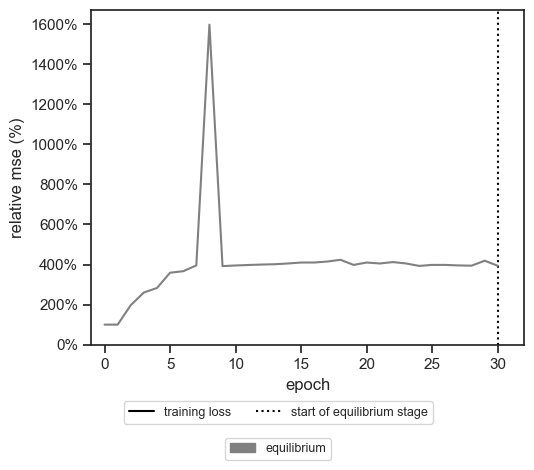

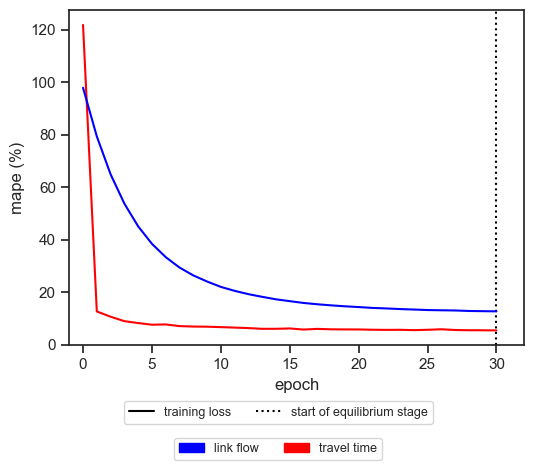

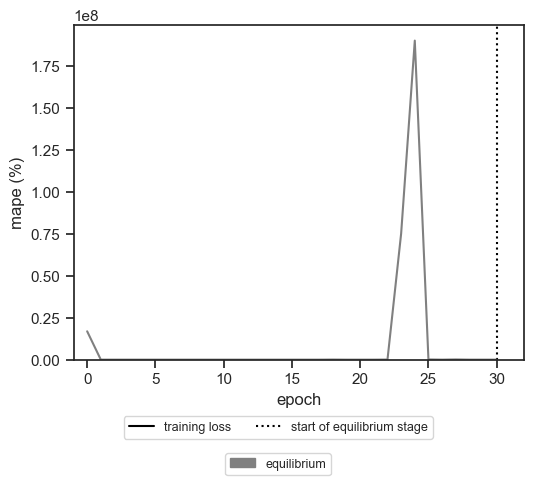

In [43]:
plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            # curves=['travel time', 'link flow'],
                            curves=['travel time', 'link flow'],
                            epochs_end_learning_stage = _EPOCHS['learning']
                            )

plt.savefig('output/figures/results/fresno-relative-mse-tvodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            curves=['equilibrium'],
                            epochs_end_learning_stage=_EPOCHS['learning'])

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            curves=['travel time', 'link flow'],
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                            yaxis_label='mape (%)')

plt.savefig('output/figures/results/fresno-mape-tvodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                            curves=['equilibrium'],
                            yaxis_label='mape (%)')

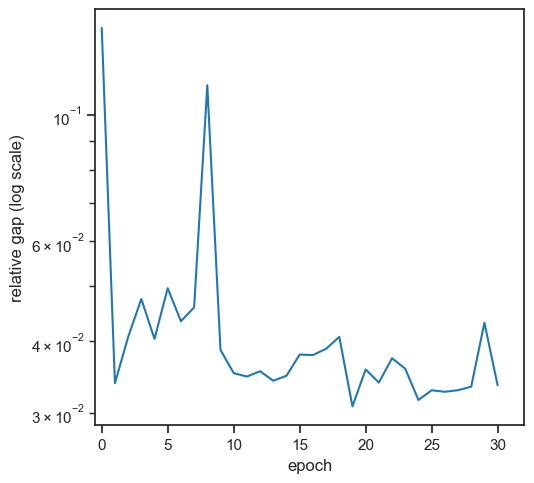

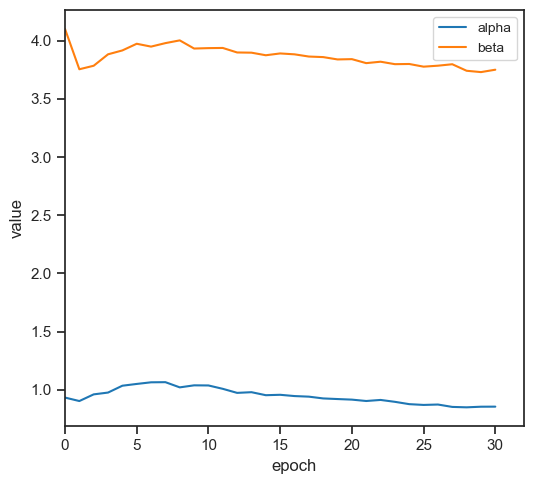

In [44]:
fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['tvodlulpe'].assign(
        relative_gap=np.abs(train_results_dfs['tvodlulpe']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=_XTICKS_SPACING)

#ax.set_ylim(ymin=1e-2, ymax = 5.5e-2)
#ax.set_ylim(ymin=1e-2)
ax.set_xlim(xmin=-0.5)
ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()

plt.savefig('output/figures/results/fresno-relative-gap-tvodlulpe.png')

plt.show()

plot_convergence_estimates(estimates=train_results_dfs['tvodlulpe'][['epoch', 'alpha', 'beta']],
                           xticks_spacing=_XTICKS_SPACING)
plt.show()

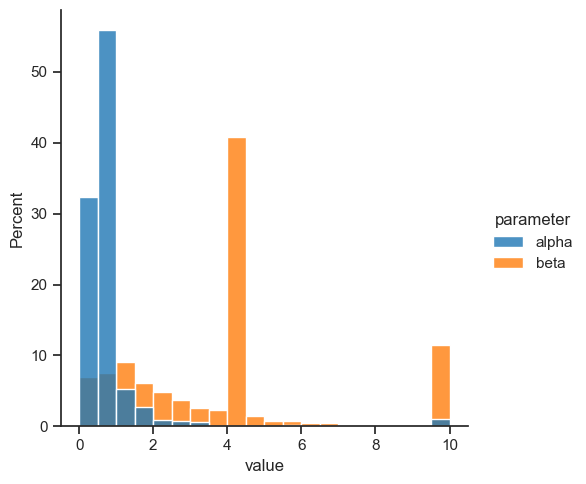

             tt     tt_sd  median_inc  incidents  bus_stops  intersections  \
6-7   -3.178089 -4.024827         0.0  -4.311056  -0.752633      -4.680222   
7-8   -2.994826 -3.777027         0.0  -4.219244   0.000000      -4.801262   
8-9   -3.249880 -4.696189         0.0  -4.383924   0.000000      -4.672889   
15-16 -2.991746 -0.569660         0.0  -4.660095   0.000000      -4.781295   
16-17 -3.396238 -3.150915         0.0  -4.754893   0.000000      -4.860311   
17-18 -2.897334 -3.009655         0.0  -5.154815  -0.177489      -4.887686   

       hour  
6-7       6  
7-8       7  
8-9       8  
15-16    15  
16-17    16  
17-18    17  


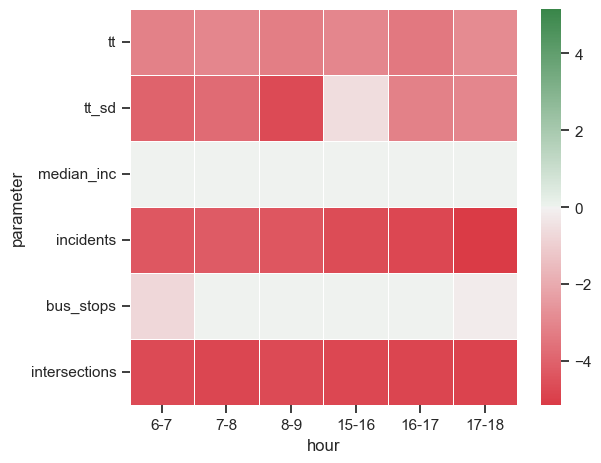

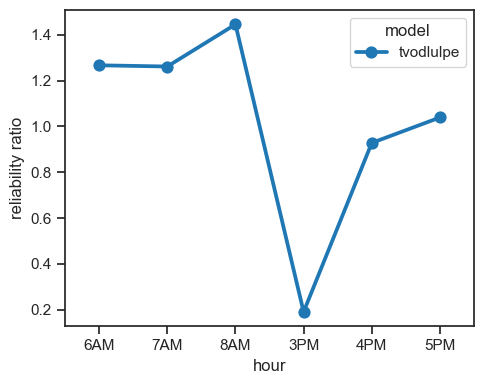

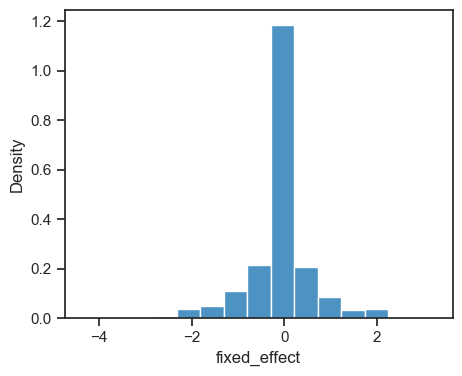

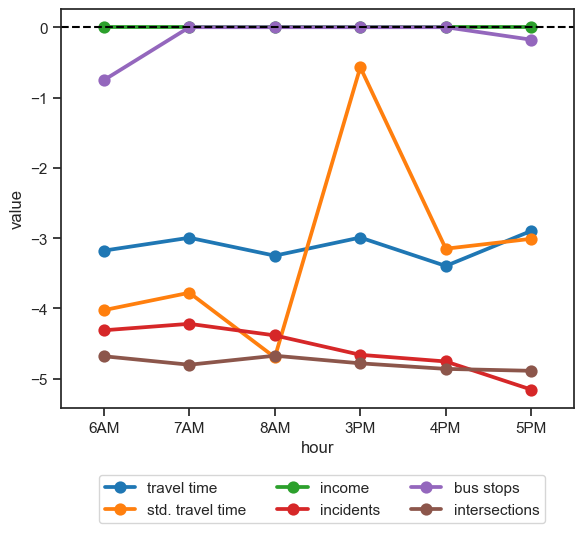

In [45]:
#sns.displot(plot_data, x="value", hue="parameter", multiple="stack", kind="hist", alpha=0.8, norm_hist=True)

plot_data = pd.melt(pd.DataFrame({'alpha': models['tvodlulpe'].performance_function.alpha,
                              'beta': models['tvodlulpe'].performance_function.beta}), var_name='parameter')

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
# sns.histplot(plot_data, x="value", stat='density', hue="parameter", alpha =0.8, ax = ax, binwidth = 0.5)

sns.displot(plot_data, x="value", kind="hist", stat='percent', common_norm=False, hue = "parameter", alpha=0.8, facet_kws=dict(sharey=False, sharex = False), binwidth = 0.5)

plt.savefig('output/figures/results/fresno-distribution-link-performance-parameters-tvodlulpe.png')

plt.show()

# Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
theta_df = plot_utility_parameters_periods(models['tvodlulpe'], period_keys = period_keys, period_feature='hour')

print(theta_df)
#print(theta_df.values)

plot_rr_by_period(models['tvodlulpe'],period_keys, model_key = 'tvodlulpe', period_feature='hour')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
sns.histplot(pd.DataFrame({'fixed_effect': np.array(models['tvodlulpe'].fixed_effect)}), stat='density', x="fixed_effect", alpha=0.8, ax = ax, binwidth=0.5)
plt.show()

theta_df = plot_utility_parameters_periods(models['tvodlulpe'], period_keys=period_keys, period_feature='hour', plot = False).reset_index().\
    drop(['hour','index'], axis = 1).reset_index().rename(columns = {'index':'period'})

# theta_df = pd.melt(theta_df.assign(rr = theta_df.apply(compute_rr, axis=1)), id_vars = 'period', var_name = 'parameter').assign(group = 'utility').\
#     replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 'rr': 'reliability ratio', 's': 'intersections', 'bus_stops': 'bus stops', 'median_inc': 'income'})

theta_df = pd.melt(theta_df, id_vars = 'period', var_name = 'parameter').assign(group = 'utility').\
    replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 'rr': 'reliability ratio', 's': 'intersections', 'bus_stops': 'bus stops', 'median_inc': 'income'})

theta_df['hour'] = theta_df['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models['tvodlulpe'].period_dict.items()})

fig, axs = plot_parameters(df = theta_df, n_cols_legend = 3, figsize = (6,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-utility-periods-tvodlulpe.png')

plt.show()

/Users/pablo/github/nesuelogit/src/nesuelogit/visualizations.py:793: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.pointplot(data=total_trips_by_hour, x=period_feature, y='total_trips', ax=ax,


(           historic_od          6AM           7AM          8AM          3PM  \
 1618 175     1840.4001  1034.519043  1.227143e+03  1035.817139  1225.931519   
      694     1182.4533   563.787537  7.090125e+02   581.135315   692.670593   
 42   1617    1139.6952   473.823212  5.455141e+02   378.394989   421.225433   
 693  1617    1077.8859   390.832489  4.286817e+02   372.989807   415.293457   
 272  1614     598.5315     0.000042  2.216645e-07     0.089355     0.008688   
 701  1629     577.9746   589.499512  6.175693e+02   464.369324   528.125000   
 226  1651     472.3362   301.488434  2.882078e+02   321.492859   435.370728   
 220  1688     446.1534   414.221191  4.274252e+02   447.108612   452.946899   
 104  1693     430.1766   406.677032  4.108335e+02   379.199860   480.913696   
 871  1679     428.9796   453.864197  4.521235e+02   450.917297   446.043793   
 1615 88       426.7179    22.086445  5.891082e-02     0.025008     2.694849   
 807  1650     418.2822   271.374176  2.

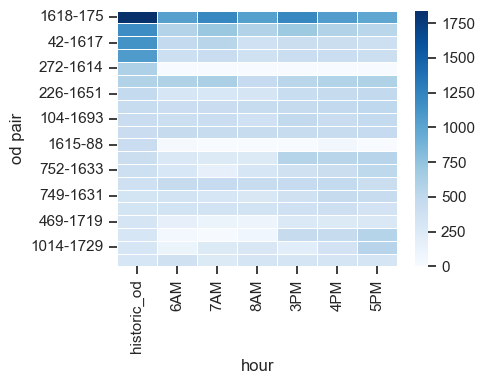

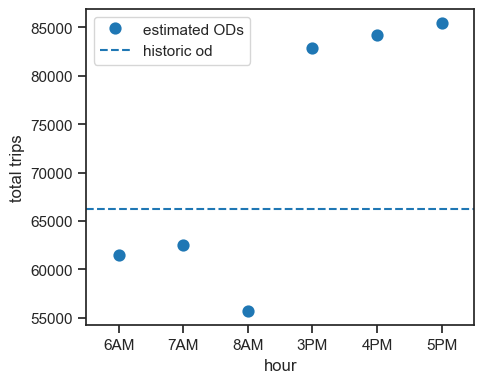

In [46]:
# Plot heatmap with flows of top od pairs
plot_top_od_flows_periods(models['tvodlulpe'],
                          historic_od= network.q.flatten(),
                          period_keys = period_keys,
                          period_feature='hour', top_k=20)

In [47]:
print(f"theta = "
      f"{dict(zip(models['tvodlulpe'].utility.true_values.keys(), list(np.mean(models['tvodlulpe'].theta.numpy(), axis=0))))}")

print(f"alpha = {np.mean(models['tvodlulpe'].performance_function.alpha): 0.2f}, "
          f"beta  = {np.mean(models['tvodlulpe'].performance_function.beta): 0.2f}")

print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['tvodlulpe'].q - network.q.flatten())): 0.2f}")

print(f"Avg observed OD: {np.mean(np.abs(network.q.flatten())): 0.2f}")

theta = {'tt': -3.1180189, 'tt_sd': -3.2047122, 'median_inc': 0.0, 'incidents': -4.5806713, 'bus_stops': -0.15502034, 'intersections': -4.7806106}
alpha =  0.85, beta  =  3.75
Avg abs diff of observed and estimated OD:  9.61
Avg observed OD:  9.51


In [48]:
metrics_df = models['tvodlulpe'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score},
                                                      X=XT_train, Y=YT_train).assign(dataset='training')
metrics_df = pd.concat([metrics_df,
                        models['tvodlulpe'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score},
                                                                 X=XT_val, Y=YT_val).assign(dataset='validation'),
                        compute_benchmark_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score}, Y_ref=YT_train,
                                                  Y=YT_val).assign(
                            dataset='benchmark')
                        ])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])


metric                     mape      mse       r2
component   dataset                              
equilibrium training   1.52e+03 1.49e+04     0.98
            validation 2.17e+13 3.97e+04    0.947
flow        benchmark      56.9 5.99e+05  -0.0567
            training       12.6 4.75e+04    0.922
            validation     19.6 1.58e+05    0.733
traveltime  benchmark      55.2   0.0626 -0.00022
            training       6.16  0.00199     0.97
            validation       10  0.00491    0.919


### TVGODLULPE

In [49]:
print('\ntvgodlulpe: Time specific utility and generation, and link specific parameters for performance functions')

# To report runtime
t0 = time.time()

def create_tvgodlulpe_model():
    return create_model(
        n_periods = n_periods,
        network = network,
        performance_function = create_mlp(network = network,
                                          poly_order = 4, pretrain = False, link_specific = False),
        historic_g= generated_trips,
        generation = True,
        generation_trainable = True,
        utility_trainable = True)

models['tvgodlulpe'], _ = create_tvgodlulpe_model()
models['tvgodlulpe'].key = 'tvgodlulpe'


tvgodlulpe: Time specific utility and generation, and link specific parameters for performance functions


In [50]:
# May remove validation set for faster training.
train_results_dfs['tvgodlulpe'], val_results_dfs['tvgodlulpe'] = models['tvgodlulpe'].fit(
    XT_train, YT_train, XT_val, YT_val,
    node_data=nodes_df,
    optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
                 'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])},
    batch_size=_BATCH_SIZE,
    # batch_size=None,
    loss_weights= _LOSS_WEIGHTS,
    loss_metric=_LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    alternating_optimization=_ALTERNATING_OPTIMIZATION,
    pretrain_link_flows = True,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
    epochs=_EPOCHS)

print(f'runtime: {time.time()-t0:0.1f} [s]')

# Save model weights for prediction analyses
models['tvgodlulpe'].save_weights(models['tvgodlulpe']._filepath_weights)
print(f"\nModel weights were saved at '{models['tvgodlulpe']._filepath_weights}'")


Model training

Pretraining generation weights

period 0 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 1 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 2 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 3 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 4 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 5 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}

Link flows and travel times were pretrained with single pass of traffic assignment
Benchmark metrics using historical mean in training data to make predictions in the validation set: 


    component    value metric
0        flow       57   mape
1  traveltime       55   mape
0        flow    6e+05    mse
1  traveltime    0.063    mse
0        flow   -0.057     r2
1  traveltime -0.00022     r2

hyperparameters los

In [51]:
# models['tvgodlulpe'].build()
# models['tvgodlulpe'].load_weights("output/models/230623142010_tvgodlulpe_fresno.h5")
# models['tvgodlulpe'].update_predictions(XT_train, update_period_dict = True)

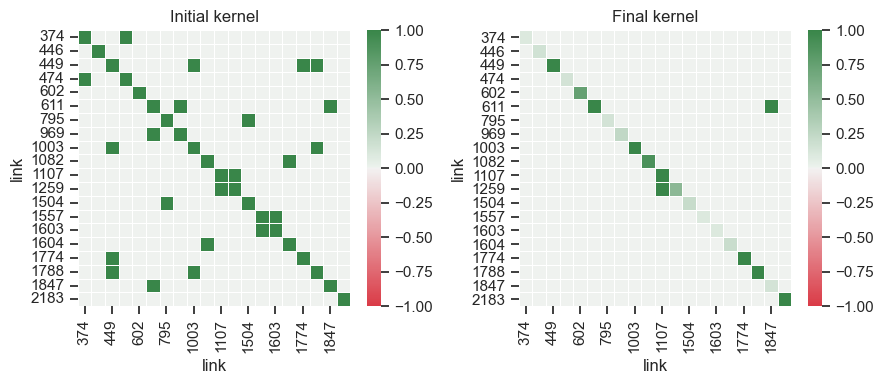

Final weights interaction:
 [[0.7434 0.     0.     ... 0.     0.     0.    ]
 [0.     0.144  0.     ... 0.     0.     0.    ]
 [0.     7.1534 1.0026 ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.9301 0.     0.    ]
 [0.     0.     0.     ... 0.     1.3259 0.    ]
 [0.     0.     0.     ... 0.     0.     1.    ]]

Initial weights interaction:
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [52]:
selected_links = np.random.choice(range(network.get_n_links()), 20, replace=False)

#weights_interaction = models['tvgodlulpe'].performance_function.weights[1].numpy()
weights_interaction = models['tvgodlulpe'].performance_function.model.layers[0].kernel_matrix.numpy()
initial_weights_interaction = models['tvgodlulpe'].performance_function.kernel_constraint.initial_values.numpy()
# Plot sign of values in flow interaction matrix
plot_flow_interaction_matrix(
    flow_interaction_matrix=weights_interaction,
    masking_matrix = initial_weights_interaction,
    # flow_interaction_matrix=np.where(weights_interaction>0, 1, -1)*np.where(weights_interaction==0, 0, 1),
    # masking_matrix = np.where(initial_weights_interaction>0, 1, -1)*np.where(initial_weights_interaction==0, 0, 1),
    links_ids = selected_links + 1,
    # vmin = -0.05, vmax = 0.05
    vmin = -1, vmax = 1
)

plt.savefig('output/figures/results/fresno-kernel-link-performance-functions-tvgodlulpe.png')

plt.show()

print(f'Final weights interaction:\n {weights_interaction}')
print(f'\nInitial weights interaction:\n',initial_weights_interaction)

# non_diagonal_mlp_weights = weights[~np.eye(weights.shape[0], dtype=bool)]
# print(f"Percentage of non-diagonal terms that are non-positive: {len(non_diagonal_mlp_weights[(non_diagonal_mlp_weights<=0)])/len(non_diagonal_mlp_weights):.2%}")

# non_zero_elements = weights_interaction[np.where(models['tvgodlulpe'].performance_function.kernel_constraint.initial_values.numpy()>0)]
# print(f"Percentage of non-zero terms that are positive: {len(non_zero_elements[(non_zero_elements>0)])/len(non_zero_elements):.2%}")

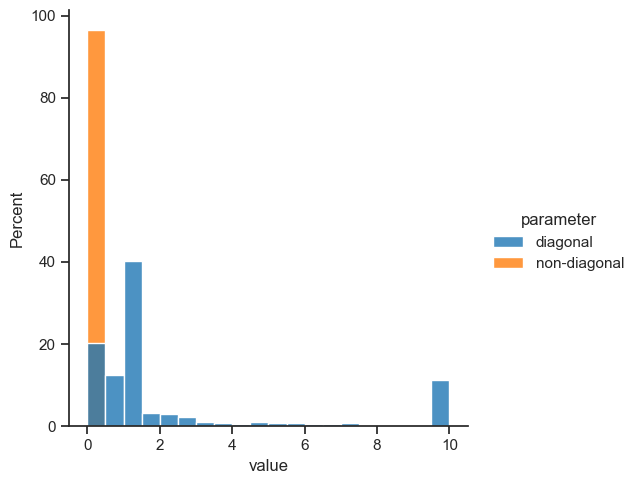

                 value  value_abs
parameter                        
diagonal      2.248898   2.248898
non-diagonal  0.111902   0.111902
              value
parameter          
diagonal       2413
non-diagonal  12314


In [53]:
# Distribution of weight in interaction flow matrix. Elements that are set to zero by default are excluded from non-diagonal
plot_data = pd.concat([pd.DataFrame({'value': tf.linalg.diag_part(weights_interaction).numpy().flatten(), 'parameter': 'diagonal'}),
                                  pd.DataFrame({'value': weights_interaction[np.where(~np.eye(weights_interaction.shape[0],dtype=bool)*models['tvgodlulpe'].performance_function.kernel_constraint.adjacency_constraint_matrix)], 'parameter': 'non-diagonal'})])

sns.displot(data = plot_data, x="value", kind="hist", stat='percent', common_norm=False, hue = "parameter", alpha=0.8,
            facet_kws=dict(sharey=False, sharex = False), binwidth = 0.5) # , col="parameter"

plt.savefig('output/figures/results/fresno-distribution-link-performance-parameters-tvgodlulpe.png')

plt.show()

plot_data['value_abs'] = plot_data.value.abs()

print(plot_data.groupby('parameter')[['value', 'value_abs']].mean())
print(plot_data.groupby('parameter')[['value']].count())

In [54]:
# Weight of polynomial
print(f"polynomial weights {tf.reduce_mean(models['tvgodlulpe'].performance_function.polynomial_layer.poly_weights,0).numpy()}")

polynomial weights [0.059  0.1054 0.1346 0.1513]


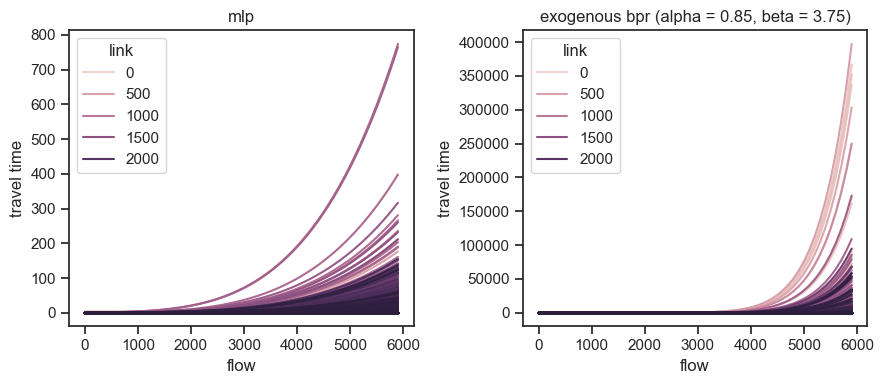

In [55]:
flow_range = range(0,6000,100)
sharey = False

plot_performance_functions(model = models['tvgodlulpe'],
                           network = network,
                           marginal = False,
                           # alpha=models['tvgodlulpe'].performance_function.polynomial_layer.alpha_prior,
                           # beta=models['tvgodlulpe'].performance_function.polynomial_layer.beta_prior,
                           alpha=models['tvodlulpe'].performance_function.alpha,
                           beta=models['tvodlulpe'].performance_function.beta,
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.savefig('output/figures/results/fresno-comparison-all-link-performance-functions-tvgodlulpe.png')

plt.show()

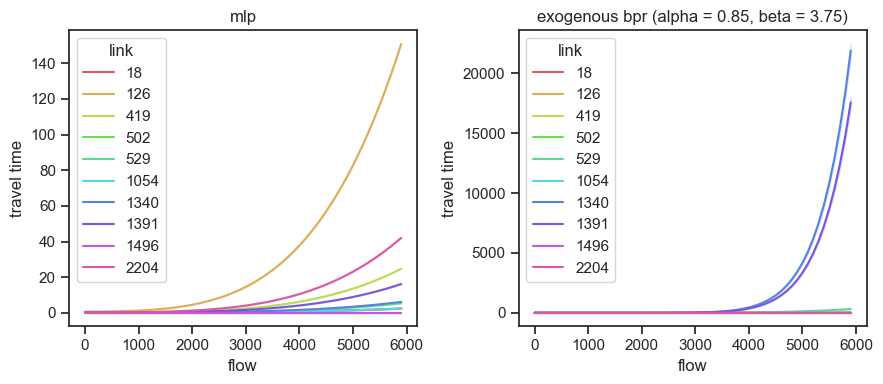

In [56]:
selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)

plot_performance_functions(model = models['tvgodlulpe'],
                           network = network,
                           marginal = True,
                           selected_links = selected_links,
                           # alpha = 0.15*np.ones(network.get_n_links()),
                           # beta = 4*np.ones(network.get_n_links()),
                           alpha=models['tvodlulpe'].performance_function.alpha,
                           beta=models['tvodlulpe'].performance_function.beta,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )
plt.show()

# plot_performance_functions(model = models['tvgodlulpe'],
#                            network = network,
#                            marginal = False,
#                            selected_links = selected_links,
#                            # alpha=models['tvgodlulpe'].performance_function.polynomial_layer.alpha_prior,
#                            # beta=models['tvgodlulpe'].performance_function.polynomial_layer.beta_prior,
#                            alpha=models['tvodlulpe'].performance_function.alpha,
#                            beta=models['tvodlulpe'].performance_function.beta,
#                            palette = sns.color_palette("hls", len(selected_links)),
#                            sharey = sharey,
#                            flow_range = flow_range
#                            )
#
# plt.show()

# plot_performance_functions(model = models['tvgodlulpe'],
#                                network = network,
#                                marginal = False,
#                                selected_links = selected_links,
#                                alpha = 0.15,
#                                beta = 4,
#                                palette = sns.color_palette("hls", len(selected_links)),
#                                sharey = sharey,
#                                flow_range = flow_range
#                                )
# plt.show()

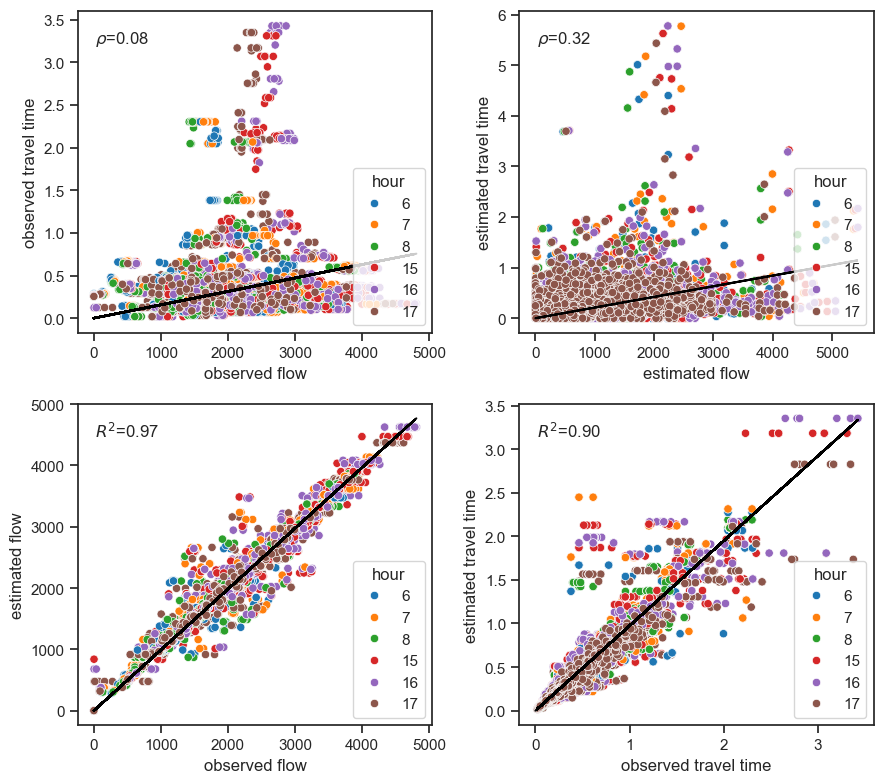

In [57]:
fig, axs = plot_flow_vs_traveltime(model = models['tvgodlulpe'],
                        observed_traveltime=models['tvgodlulpe'].mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= models['tvgodlulpe'].mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-tvgodlulpe.png')

plt.show()

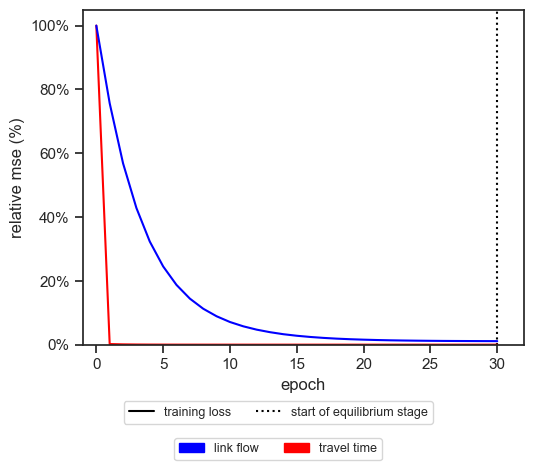

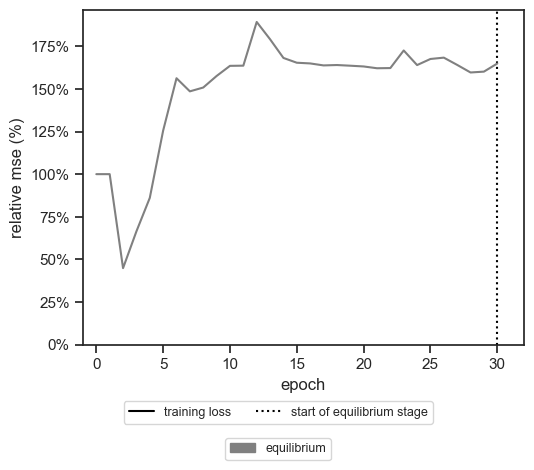

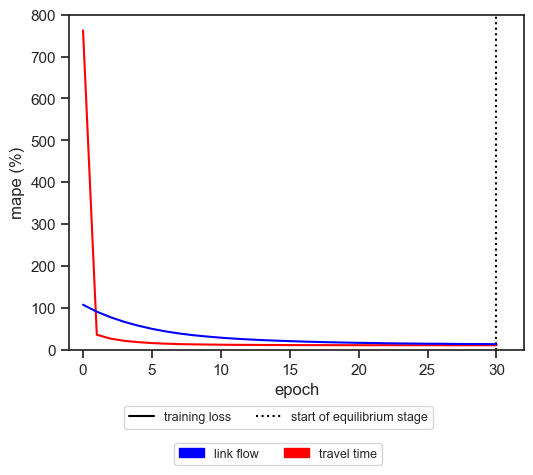

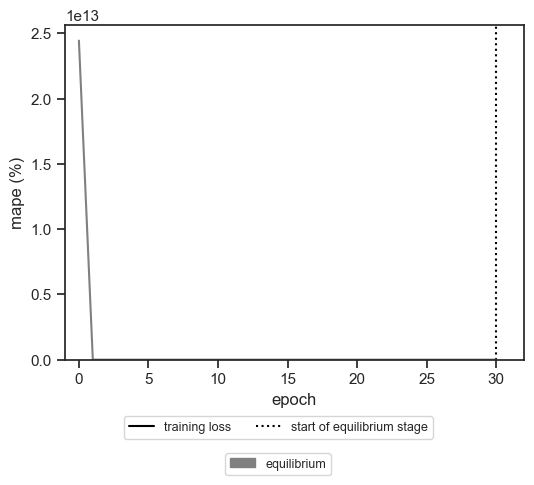

In [58]:
plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'], val_losses=val_results_dfs['tvgodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            # curves=['travel time', 'link flow'],
                            curves=['travel time', 'link flow'],
                            epochs_end_learning_stage = _EPOCHS['learning']
                            )

plt.savefig('output/figures/results/fresno-relative-mse-tvgodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'], val_losses=val_results_dfs['tvgodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            curves=['equilibrium'],
                            epochs_end_learning_stage=_EPOCHS['learning'])

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'], val_losses=val_results_dfs['tvgodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            curves=['travel time', 'link flow'],
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                            yaxis_label='mape (%)')

plt.savefig('output/figures/results/fresno-mape-tvgodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'], val_losses=val_results_dfs['tvgodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                            curves=['equilibrium'],
                            yaxis_label='mape (%)')

plt.show()

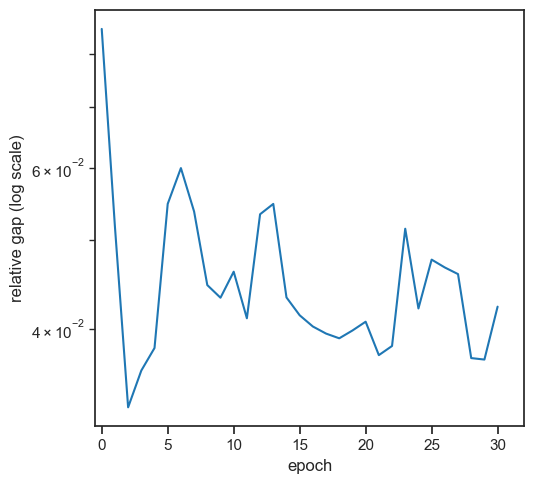

In [59]:
fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['tvgodlulpe'].assign(
        relative_gap=np.abs(train_results_dfs['tvgodlulpe']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=_XTICKS_SPACING)

#ax.set_ylim(ymin=1e-2)
# ax.set_ylim(ymin=1e-2, ymax = 5.5e-2)
ax.set_xlim(xmin=-0.5)
ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()

plt.savefig('output/figures/results/fresno-relative-gap-tvgodlulpe.png')

plt.show()

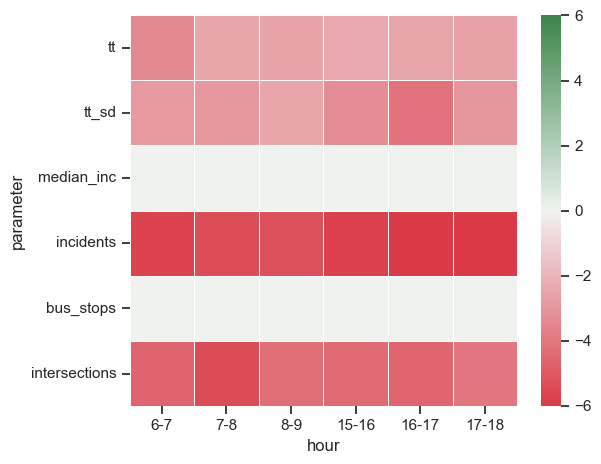

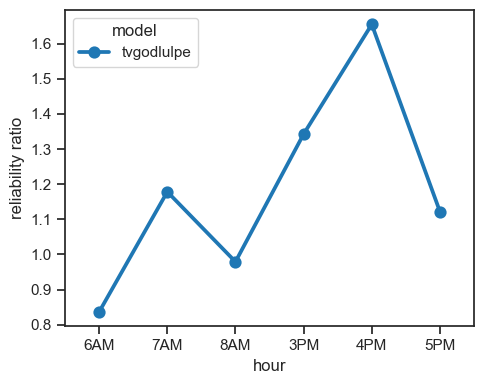

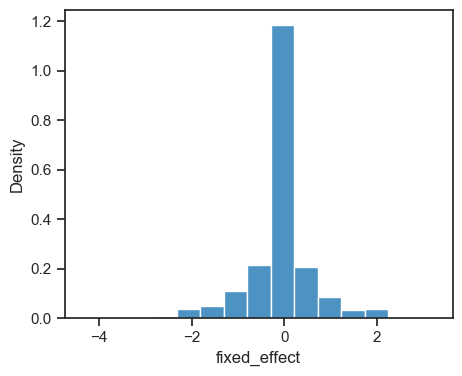

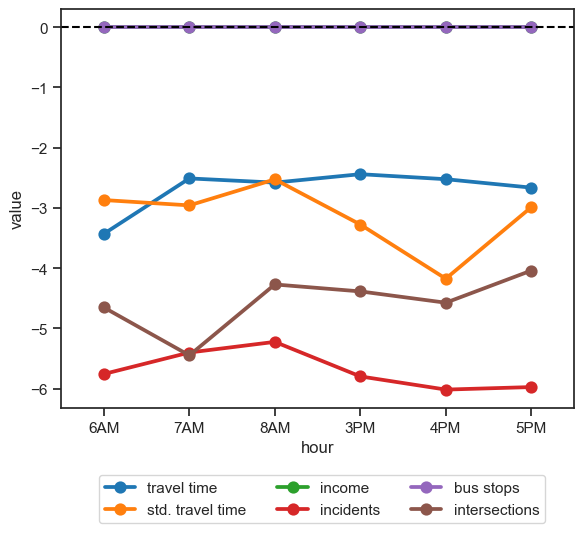

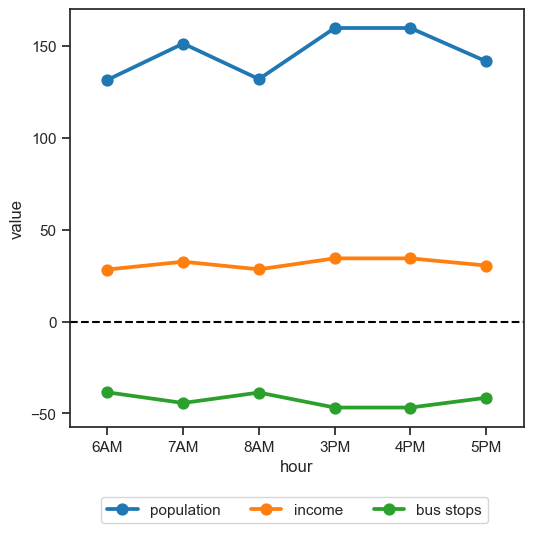

Theta: [[-3.4299 -2.5102 -2.5797 -2.4398 -2.5231 -2.6629]
 [-2.8692 -2.9576 -2.5258 -3.2753 -4.1749 -2.9878]
 [ 0.      0.      0.      0.      0.      0.    ]
 [-5.7572 -5.4003 -5.2236 -5.7971 -6.0158 -5.974 ]
 [ 0.      0.      0.      0.      0.      0.    ]
 [-4.6523 -5.4476 -4.2704 -4.3858 -4.5736 -4.0404]]
Kappa: [[131.4958 151.2198 131.8887 159.6779 159.6841 141.5333]
 [ 28.293   32.5369  28.3776  34.3568  34.3581  30.4527]
 [-38.5438 -44.3253 -38.659  -46.8045 -46.8064 -41.486 ]]


In [60]:
# Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
theta_df = plot_utility_parameters_periods(models['tvgodlulpe'], period_keys = period_keys, period_feature='hour')
#print(theta_df.values)

plot_rr_by_period(models['tvgodlulpe'], period_keys, model_key = 'tvgodlulpe', period_feature='hour')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
sns.histplot(pd.DataFrame({'fixed_effect': np.array(models['tvodlulpe'].fixed_effect)}), stat='density', x="fixed_effect", alpha=0.8, ax = ax, binwidth=0.5)
plt.show()

# Plot parameters by period
theta_df = plot_utility_parameters_periods(models['tvgodlulpe'], period_keys=period_keys, period_feature='hour', plot = False).reset_index().\
    drop(['hour','index'], axis = 1).reset_index().rename(columns = {'index':'period'})

# theta_df = pd.melt(theta_df.assign(rr = theta_df.apply(compute_rr, axis=1)), id_vars = 'period', var_name = 'parameter').assign(group = 'utility')

theta_df = pd.melt(theta_df, id_vars = 'period', var_name = 'parameter').assign(group = 'utility')

kappa_df = pd.concat([pd.DataFrame({'period': [period], 'parameter': [feature], 'value': [models['tvgodlulpe'].kappa[period, i].numpy()]}) for period in range(models['tvgodlulpe'].kappa.shape[0]) for i, feature in enumerate(models['tvgodlulpe'].generation.features)]).assign(group = 'generation')

parameters_df = pd.concat([theta_df, kappa_df]).\
    replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 's': 'intersections', 'bus_stops': 'bus stops', 'median_inc': 'income', 'rr': 'reliability ratio'})

parameters_df['hour'] = parameters_df['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models['tvgodlulpe'].period_dict.items()})

fig, ax = plot_parameters(df = parameters_df[parameters_df.group == 'utility'], n_cols_legend = 3, figsize = (6,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-utility-periods-tvgodlulpe.png')

plot_parameters(df = parameters_df[parameters_df.group == 'generation'], n_cols_legend = 3, figsize = (5.5,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-generation-periods-tvgodlulpe.png')

plt.show()

print('Theta:', models['tvgodlulpe'].theta.numpy().T)
print('Kappa:', models['tvgodlulpe'].kappa.numpy().T)

/Users/pablo/github/nesuelogit/src/nesuelogit/visualizations.py:793: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.pointplot(data=total_trips_by_hour, x=period_feature, y='total_trips', ax=ax,


(           historic_od         6AM         7AM         8AM         3PM  \
 1618 175     1840.4001    0.005838    0.013055    0.015830    0.007929   
      694     1182.4533    0.005614    0.014784    0.016467    0.011167   
 42   1617    1139.6952    0.333910    1.879675  247.260956    5.048954   
 693  1617    1077.8859   96.045647  194.588577   11.370667  246.300018   
 272  1614     598.5315    0.043515    0.070802    0.042144    0.049170   
 701  1629     577.9746    0.560999    6.678464    2.350182    1.316475   
 226  1651     472.3362    0.194990    1.477639    1.339113    3.933277   
 220  1688     446.1534    5.459724    4.575401    1.726589    2.091933   
 104  1693     430.1766    1.756642   15.621783    1.974739    0.980169   
 871  1679     428.9796    0.340230    3.228900    0.353628    0.841116   
 1615 88       426.7179  605.826172  685.024841  591.986328  741.200562   
 807  1650     418.2822    1.402199    7.812274   12.246459   56.123707   
 752  1633     392.5845  

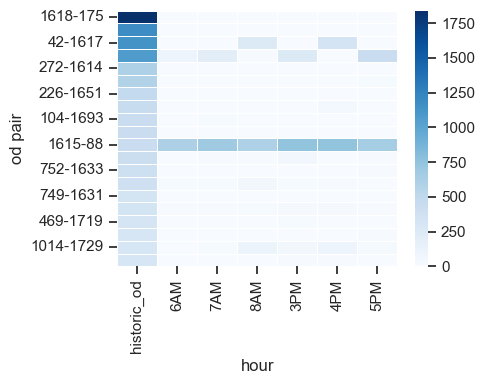

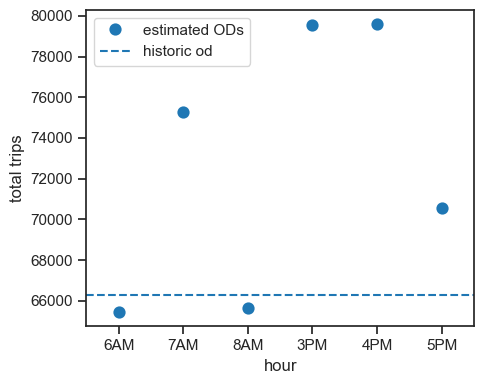

In [61]:
# Plot heatmap with flows of top od pairs
plot_top_od_flows_periods(models['tvgodlulpe'],
                          historic_od= network.q.flatten(),
                          period_keys = period_keys,
                          period_feature='hour', top_k=20)

In [62]:
print(f"theta = "
      f"{dict(zip(models['tvgodlulpe'].utility.true_values.keys(), list(np.mean(models['tvgodlulpe'].theta.numpy(), axis=0))))}")
print(f"kappa= "
      f"{dict(zip(models['tvgodlulpe'].generation.features, list(np.mean(models['tvgodlulpe'].kappa.numpy(), axis=0))))}")

if models['tvgodlulpe'].performance_function.type == 'bpr':
    print(f"alpha = {np.mean(models['tvgodlulpe'].performance_function.alpha): 0.2f}, "
          f"beta  = {np.mean(models['tvgodlulpe'].performance_function.beta): 0.2f}")

print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['tvgodlulpe'].q - network.q.flatten())): 0.2f}")

print(f"Avg observed OD: {np.mean(np.abs(network.q.flatten())): 0.2f}")

theta = {'tt': -2.6909378, 'tt_sd': -3.1317596, 'median_inc': 0.0, 'incidents': -5.6946483, 'bus_stops': 0.0, 'intersections': -4.5616817}
kappa= {'population': 145.91658, 'income': 31.395859, 'bus_stops': -42.770832}
Avg abs diff of observed and estimated OD:  16.20
Avg observed OD:  9.51


In [63]:
metrics_df = models['tvgodlulpe'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score},
                                                      X=XT_train, Y=YT_train).assign(dataset='training')
# metrics_df = pd.concat([metrics_df,
#                         models['tvgodlulpe'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score},
#                                                                  X=XT_val, Y=YT_val).assign(dataset='validation'),
#                         compute_benchmark_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score}, Y_ref=YT_train,
#                                                   Y=YT_val).assign(
#                             dataset='benchmark')
#                         ])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])
print(f'runtime: {time.time()-t0:0.1f} [s]')

metric                mape      mse    r2
component   dataset                      
equilibrium training  28.2 2.74e+04 0.952
flow        training  12.8 4.84e+04 0.921
traveltime  training  10.7  0.00626 0.905
runtime: 3973.1 [s]


# Forecasting

In [64]:
generation_factors = compute_generation_factors(period_column=XT_train[:, :, -1, None].numpy(),
                                                flow_column=YT_train[:,:,1, None].numpy(), reference_period=10)

print(generation_factors)

n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

growth_factor = 7.9/6.6

generated_trips = growth_factor*generation_factors.values[:,np.newaxis]*compute_generated_trips(
    q = network.q.flatten()[np.newaxis,:], ods= network.ods, n_nodes = len(network.nodes))

period_id
0.0    0.823474
1.0    0.946993
2.0    0.825935
3.0    0.999961
4.0    1.000000
5.0    0.886333
Name: flow, dtype: float32


## TVODLULPE

In [65]:
# models['reference-model'], _ = create_model(
#     n_periods=n_periods, network=network, historic_g=generation_factors.values[:, np.newaxis] * generated_trips)
#
# train_results_dfs['reference-model'], val_results_dfs['reference-model'] = models['reference-model'].fit(
#     XT_train, YT_train, XT_val, YT_val,
#     node_data=nodes_df,
#     optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
#                  'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
#                  },
#     batch_size=_BATCH_SIZE,
#     # loss_weights= _LOSS_WEIGHTS,
#     loss_weights = {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1},
#     loss_metric=_LOSS_METRIC,
#     equilibrium_stage= True,
#     alternating_optimization= False,
#     pretrain_link_flows = True,
#     threshold_relative_gap= 2e-1,
#     epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
#     epochs=_EPOCHS)

reference_model = models['tvodlulpe']

In [66]:
# Create model for inference (make sure that the arguments are the same than those used to create the reference model)
inference_model, _ = create_model(
    n_periods= n_periods, network = network,
    performance_function = create_bpr(network = network, dtype = _DTYPE, alpha_prior = 0.9327, beta_prior = 4.1017),
    od_parameters = ODParameters(key='od',
                                 #initial_values= generation_factors.values[:,np.newaxis]*tntp_network.q.flatten(),
                                 initial_values = tf.stack(q_historic),
                                 historic_values={10: q_historic[0].flatten()},
                                 ods=network.ods,
                                 n_nodes = len(network.nodes),
                                 n_periods=n_periods,
                                 time_varying=True,
                                 trainable=True),
    generation = False,
    utility_trainable = True
)

inference_model.build()
#inference_model.update_predictions(XT_train, update_period_dict = True)

In [67]:
# inference_model.load_weights("output/models/230616010949_tvgodlulpe_fresno.h5")
inference_model.load_weights(reference_model._filepath_weights)

### - Model estimated with all data from 2019

In [68]:
# reference_model.load_node_data(node_data)
# This should convergence immediately when the data for prediction is equal to training set
_ = inference_model.predict(XT_train,
                        # period_dict = reference_model.period_dict,
                        node_data=nodes_df,
                        loss_metric=_LOSS_METRIC,
                        pretrain_link_flows = False,
                        batch_size= _BATCH_SIZE,
                        # optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                        # batch_size= None,
                        optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=1e-1),
                        loss_weights={'equilibrium': 1},
                        # threshold_relative_gap=5e-2,  # _RELATIVE_GAP,
                        threshold_relative_gap=_RELATIVE_GAP,
                        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
                        epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 6, batch size: 1, threshold relative gap: 0.05
training set -> timepoints: 90, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=1.6e+04, theta = [-3.118 -3.205  0.    -4.581 -0.155 -4.781], avg rr = 1.03, avg theta fixed effect = -0.056, loss prop od=1.5e+03, total trips=[6.15e+04 6.25e+04 5.57e+04 8.28e+04 8.42e+04 8.54e+04], avg alpha=0.85, avg beta=3.8, lambda eq=1, relative gap=0.034, train equilibrium loss=1.6e+04, time: 1.2

Relative gap threshold of 0.05 was achieved in equilibrium stage


In [69]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    training_metrics = inference_model.compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score},
                                                            X=XT_train, Y=YT_train)
    print(training_metrics)

# model.summary()



     component    value metric
0         flow     12.6   mape
1   traveltime     6.16   mape
2  equilibrium 1.52e+03   mape
0         flow 4.75e+04    mse
1   traveltime  0.00199    mse
2  equilibrium 1.49e+04    mse
0         flow    0.922     r2
1   traveltime     0.97     r2
2  equilibrium     0.98     r2


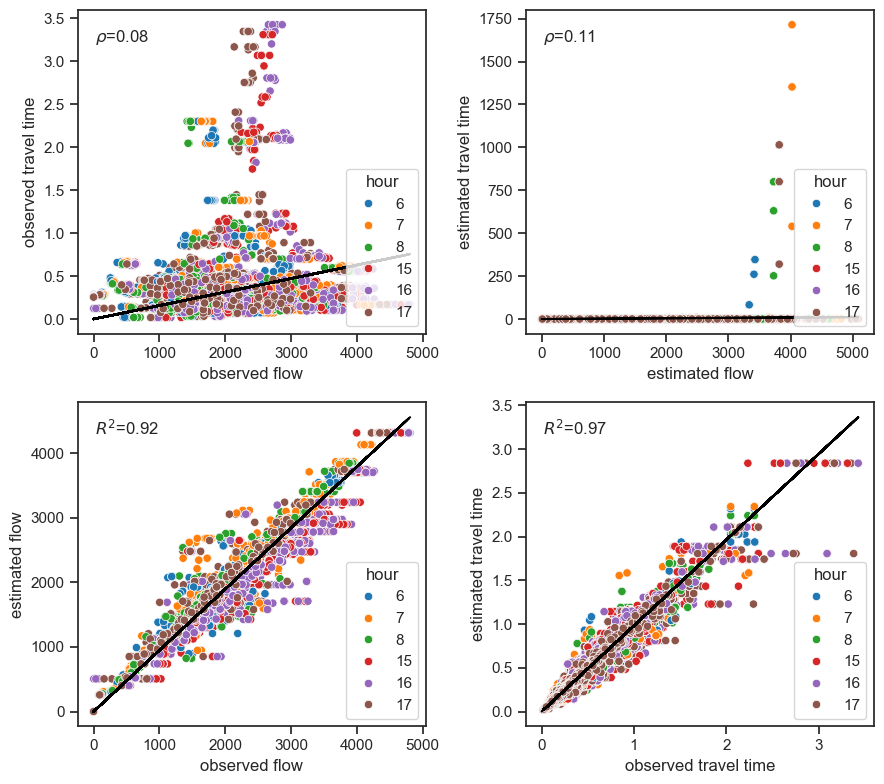

In [70]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.show()

### -Make prediction on 2020, the validation set, without computing equilibrium

In [71]:

_ = inference_model.predict(XT_val,
                            node_data=nodes_df,
                            loss_metric=_LOSS_METRIC,
                            batch_size= _BATCH_SIZE,
                            optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                            pretrain_link_flows = False,
                            # batch_size= None,
                            # optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=1e-1),
                            loss_weights={'equilibrium': 1},
                            threshold_relative_gap=float('inf'),  # _RELATIVE_GAP,
                            epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
                            epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 6, batch size: 1, threshold relative gap: inf
training set -> timepoints: 78, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=4.1e+04, theta = [-3.118 -3.205  0.    -4.581 -0.155 -4.781], avg rr = 1.03, avg theta fixed effect = -0.056, loss prop od=nan, total trips=[6.15e+04 6.25e+04 5.57e+04 8.28e+04 8.42e+04 8.54e+04], avg alpha=0.85, avg beta=3.8, lambda eq=1, relative gap=0.082, train equilibrium loss=4.1e+04, time: 1.0

Relative gap threshold of inf was achieved in equilibrium stage


In [72]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    validation_metrics = inference_model.compute_loss_metrics(metrics = {'mape': mape, 'mse': mse, 'r2': r2_score}, X = XT_val, Y = YT_val)
    print(validation_metrics)



     component    value metric
0         flow     19.6   mape
1   traveltime       10   mape
2  equilibrium 2.17e+13   mape
0         flow 1.58e+05    mse
1   traveltime  0.00491    mse
2  equilibrium 3.97e+04    mse
0         flow    0.733     r2
1   traveltime    0.919     r2
2  equilibrium    0.947     r2


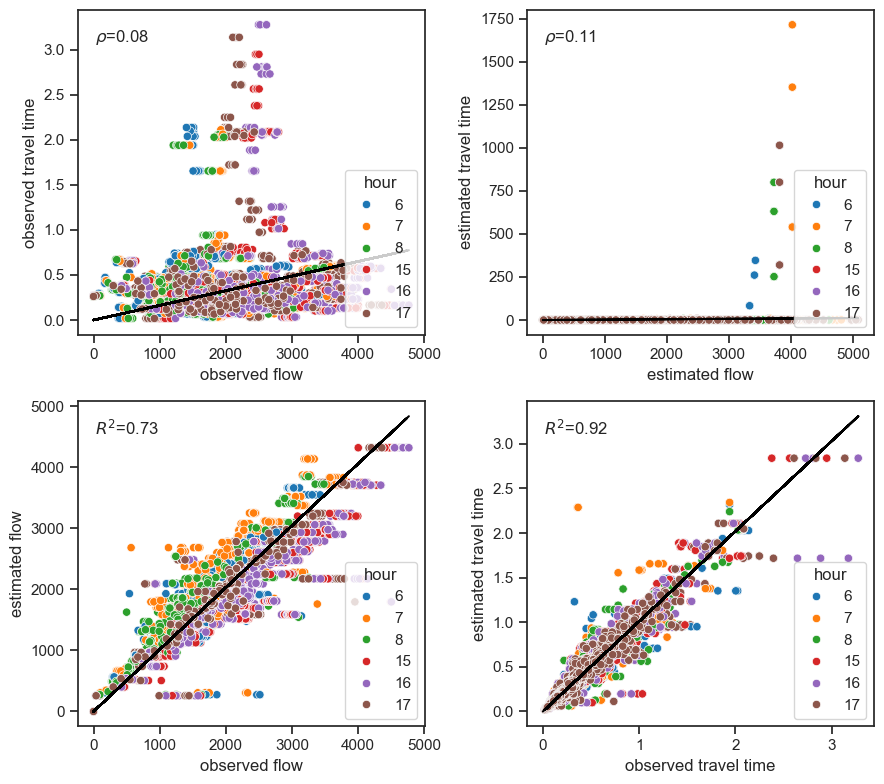

In [73]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_val[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_val[:,:,1]),
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        period_col = pd.DataFrame({'period': list(XT_val[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-outofsample-tvodlulpe-without-equilibrium.png')

plt.show()

### - Make prediction on 2020, the validation set, computing equilibrium

In [74]:

_ = inference_model.predict(XT_val,
                            node_data=nodes_df,
                            loss_metric=_LOSS_METRIC,
                            batch_size= _BATCH_SIZE,
                            optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                            pretrain_link_flows = False,
                            # batch_size= None,
                            # optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=1e-1),
                            loss_weights={'equilibrium': 1},
                            threshold_relative_gap=5e-2,  # _RELATIVE_GAP,
                            epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
                            epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 6, batch size: 1, threshold relative gap: 0.05
training set -> timepoints: 78, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=4.1e+04, theta = [-3.118 -3.205  0.    -4.581 -0.155 -4.781], avg rr = 1.03, avg theta fixed effect = -0.056, loss prop od=nan, total trips=[6.15e+04 6.25e+04 5.57e+04 8.28e+04 8.42e+04 8.54e+04], avg alpha=0.85, avg beta=3.8, lambda eq=1, relative gap=0.082, train equilibrium loss=4.1e+04, time: 1.1

1/100: train mse=3.7e+04, theta = [-3.118 -3.205  0.    -4.581 -0.155 -4.781], avg rr = 1.03, avg theta fixed effect = -0.056, loss prop od=nan, total trips=[6.15e+04 6.25e+04 5.57e+04 8.28e+04 8.42e+04 8.54e+04], avg alpha=0.85, avg beta=3.8, lambda eq=1, relative gap=0.071, train equilibrium loss=3.7e+04, time: 85.2

2/100: train mse=3.4e+04, theta = [-3.118 -3.205  0.    -4.581 -0.155 -4.781], avg rr = 1.03, avg theta fixed effect =

In [75]:
# with pd.option_context('display.float_format', '{:0.3g}'.format):
#     metrics_df = pd.concat([training_metrics.assign(dataset = 'training'),
#                             validation_metrics.assign(dataset = 'validation')])
#     print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    validation_metrics = inference_model.compute_loss_metrics(metrics = {'mape': mape, 'mse': mse, 'r2': r2_score}, X = XT_val, Y = YT_val)
    print(validation_metrics)



     component    value metric
0         flow     20.5   mape
1   traveltime     10.6   mape
2  equilibrium 1.69e+09   mape
0         flow 1.67e+05    mse
1   traveltime  0.00532    mse
2  equilibrium 2.62e+04    mse
0         flow    0.717     r2
1   traveltime    0.913     r2
2  equilibrium    0.965     r2


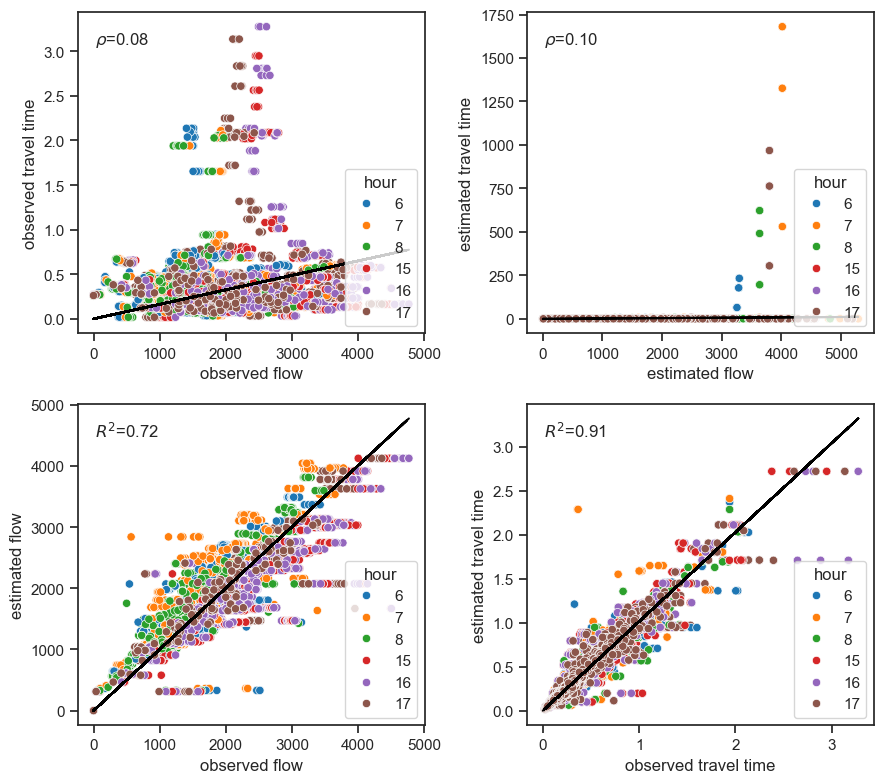

In [76]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_val[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_val[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_val[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-outofsample-tvodlulpe-with-equilibrium.png')

plt.show()

## TVGODLULPE

In [77]:
# models['reference-model'], _ = create_model(
#     n_periods=n_periods, network=network, historic_g=generation_factors.values[:, np.newaxis] * generated_trips)
#
# train_results_dfs['reference-model'], val_results_dfs['reference-model'] = models['reference-model'].fit(
#     XT_train, YT_train, XT_val, YT_val,
#     node_data=nodes_df,
#     optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
#                  'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
#                  },
#     batch_size=_BATCH_SIZE,
#     # loss_weights= _LOSS_WEIGHTS,
#     loss_weights = {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1},
#     loss_metric=_LOSS_METRIC,
#     equilibrium_stage= True,
#     alternating_optimization= False,
#     pretrain_link_flows = True,
#     threshold_relative_gap= 2e-1,
#     epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
#     epochs=_EPOCHS)

reference_model = models['tvgodlulpe']

In [78]:
# Create model for inference (make sure that the arguments are the same than those used to create the reference model)
inference_model, _ = create_tvgodlulpe_model()
# inference_model, _ = create_model(
#     n_periods = n_periods,
#     network = network,
#     performance_function = create_mlp(network = network,
#                                       poly_order = 4, alpha_prior = 1, beta_prior = 4, pretrain = False, link_specific = False),
#     historic_g= generated_trips,
#     generation = True,
#     utility_trainable = True)

inference_model.build()
#inference_model.update_predictions(XT_train, update_period_dict = True)

In [79]:
# inference_model.load_weights("output/models/230616010949_tvgodlulpe_fresno.h5")
inference_model.load_weights(reference_model._filepath_weights)

### - Model estimated with all data from 2019

In [80]:
# reference_model.load_node_data(node_data)
# This should convergence immediately when the data for prediction is equal to training set
_ = inference_model.predict(XT_train,
                        # period_dict = reference_model.period_dict,
                        node_data=nodes_df,
                        loss_metric=_LOSS_METRIC,
                        pretrain_link_flows = False,
                        batch_size= _BATCH_SIZE,
                        # optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                        # batch_size= None,
                        optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=1e-1),
                        loss_weights={'equilibrium': 1},
                        # threshold_relative_gap=5e-2,  # _RELATIVE_GAP,
                        threshold_relative_gap=_RELATIVE_GAP,
                        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
                        epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 6, batch size: 1, threshold relative gap: 0.05
training set -> timepoints: 90, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=3.1e+04, theta = [-2.691 -3.132  0.    -5.695  0.    -4.562], avg rr = 1.16, avg theta fixed effect = -0.072, loss prop od=3.8e+03, total trips=[6.55e+04 7.53e+04 6.57e+04 7.95e+04 7.96e+04 7.06e+04], polynomial weights: [5.9e-02 1.1e-01 1.3e-01 1.5e-01], kappa = [145.917  31.396 -42.771], lambda eq=1, relative gap=0.042, train equilibrium loss=3.1e+04, time: 1.2

Relative gap threshold of 0.05 was achieved in equilibrium stage


In [81]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    training_metrics = inference_model.compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score},
                                                            X=XT_train, Y=YT_train)
    print(training_metrics)

# model.summary()



     component    value metric
0         flow     12.8   mape
1   traveltime     10.7   mape
2  equilibrium     28.2   mape
0         flow 4.84e+04    mse
1   traveltime  0.00626    mse
2  equilibrium 2.74e+04    mse
0         flow    0.921     r2
1   traveltime    0.905     r2
2  equilibrium    0.952     r2


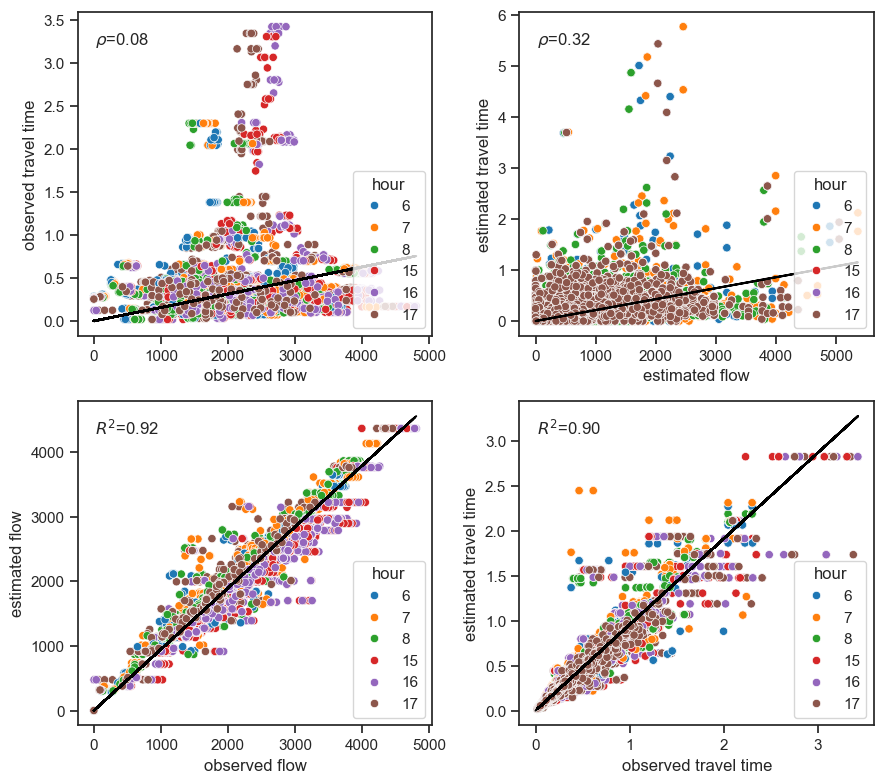

In [82]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.show()

### -Make prediction on 2020, the validation set, without computing equilibrium

In [83]:

_ = inference_model.predict(XT_val,
                            node_data=nodes_df,
                            loss_metric=_LOSS_METRIC,
                            batch_size= _BATCH_SIZE,
                            optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                            pretrain_link_flows = False,
                            # batch_size= None,
                            # optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=1e-1),
                            loss_weights={'equilibrium': 1},
                            threshold_relative_gap=float('inf'),  # _RELATIVE_GAP,
                            epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
                            epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 6, batch size: 1, threshold relative gap: inf
training set -> timepoints: 78, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=5.5e+04, theta = [-2.691 -3.132  0.    -5.695  0.    -4.562], avg rr = 1.16, avg theta fixed effect = -0.072, loss prop od=nan, total trips=[6.55e+04 7.53e+04 6.57e+04 7.95e+04 7.96e+04 7.06e+04], polynomial weights: [5.9e-02 1.1e-01 1.3e-01 1.5e-01], kappa = [145.917  31.396 -42.771], lambda eq=1, relative gap=0.088, train equilibrium loss=5.5e+04, time: 1.2

Relative gap threshold of inf was achieved in equilibrium stage


In [84]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    validation_metrics = inference_model.compute_loss_metrics(metrics = {'mape': mape, 'mse': mse, 'r2': r2_score}, X = XT_val, Y = YT_val)
    print(validation_metrics)



     component    value metric
0         flow     19.7   mape
1   traveltime     12.1   mape
2  equilibrium 7.51e+14   mape
0         flow 1.59e+05    mse
1   traveltime  0.00683    mse
2  equilibrium  4.6e+04    mse
0         flow    0.731     r2
1   traveltime    0.888     r2
2  equilibrium     0.92     r2


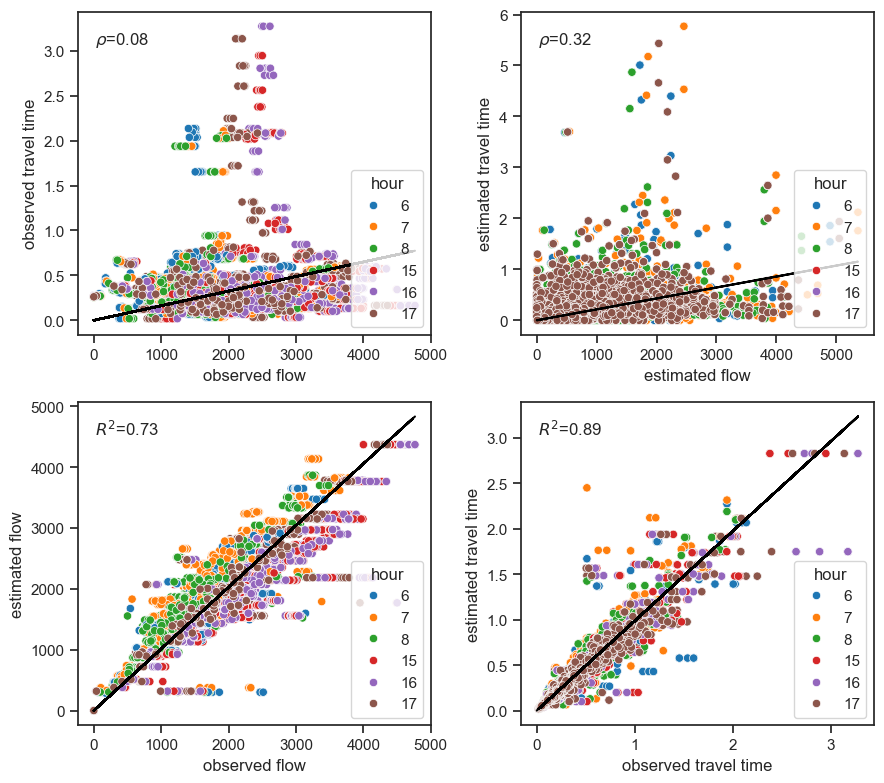

In [85]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_val[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_val[:,:,1]),
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        period_col = pd.DataFrame({'period': list(XT_val[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-outofsample-tvgodlulpe-without-equilibrium.png')

plt.show()

### - Make prediction on 2020, the validation set, computing equilibrium

In [86]:

_ = inference_model.predict(XT_val,
                            node_data=nodes_df,
                            loss_metric=_LOSS_METRIC,
                            batch_size= _BATCH_SIZE,
                            optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                            pretrain_link_flows = False,
                            # batch_size= None,
                            # optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=1e-1),
                            loss_weights={'equilibrium': 1},
                            threshold_relative_gap=5e-2,  # _RELATIVE_GAP,
                            epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
                            epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 6, batch size: 1, threshold relative gap: 0.05
training set -> timepoints: 78, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=5.5e+04, theta = [-2.691 -3.132  0.    -5.695  0.    -4.562], avg rr = 1.16, avg theta fixed effect = -0.072, loss prop od=nan, total trips=[6.55e+04 7.53e+04 6.57e+04 7.95e+04 7.96e+04 7.06e+04], polynomial weights: [5.9e-02 1.1e-01 1.3e-01 1.5e-01], kappa = [145.917  31.396 -42.771], lambda eq=1, relative gap=0.088, train equilibrium loss=5.5e+04, time: 1.2

1/100: train mse=5.1e+04, theta = [-2.691 -3.132  0.    -5.695  0.    -4.562], avg rr = 1.16, avg theta fixed effect = -0.072, loss prop od=nan, total trips=[6.55e+04 7.53e+04 6.57e+04 7.95e+04 7.96e+04 7.06e+04], polynomial weights: [5.9e-02 1.1e-01 1.3e-01 1.5e-01], kappa = [145.917  31.396 -42.771], lambda eq=1, relative gap=0.078, train equilibrium loss=5.1e+04, time: 112.

In [87]:
# with pd.option_context('display.float_format', '{:0.3g}'.format):
#     metrics_df = pd.concat([training_metrics.assign(dataset = 'training'),
#                             validation_metrics.assign(dataset = 'validation')])
#     print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    validation_metrics = inference_model.compute_loss_metrics(metrics = {'mape': mape, 'mse': mse, 'r2': r2_score}, X = XT_val, Y = YT_val)
    print(validation_metrics)



     component    value metric
0         flow     22.2   mape
1   traveltime     12.2   mape
2  equilibrium     10.8   mape
0         flow 1.88e+05    mse
1   traveltime  0.00655    mse
2  equilibrium 2.87e+04    mse
0         flow    0.681     r2
1   traveltime    0.893     r2
2  equilibrium     0.95     r2


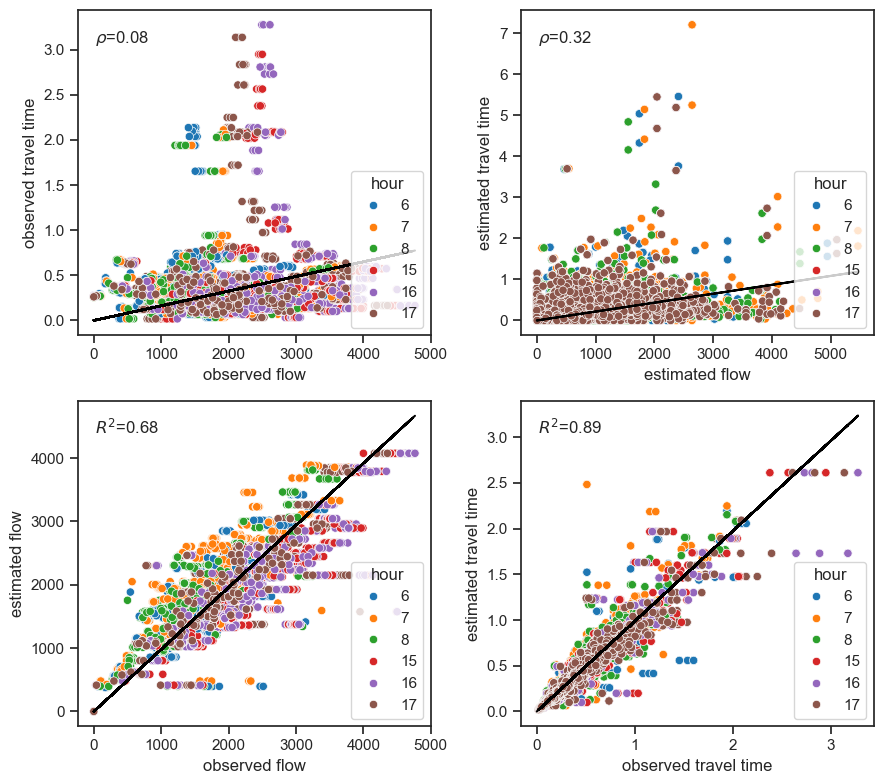

In [88]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_val[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_val[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_val[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-outofsample-tvgodlulpe-with-equilibrium.png')

plt.show()

## K-Fold Cross Validation

In [89]:
models_kfold = {}
metrics_kfold_df = {}
parameters_kfold_df = {}

### - Baselines

In [90]:
# Calculate centroids of links to compute baselines models
links_gdf['X'] = links_gdf.to_crs(2228).geometry.centroid.to_crs(4326).x
links_gdf['Y'] = links_gdf.to_crs(2228).geometry.centroid.to_crs(4326).y
coordinates = links_gdf[['X', 'Y']].values

In [91]:
# Baselines are computed for every sample
metrics_kfold_df['baselines'] = pd.DataFrame({})
n_samples = XT_val.shape[0]

t0 = time.time()
for i in range(n_samples):

    isl.printer.printIterationBar(i+1, n_samples-1, prefix='Sample:',length=20)

    metrics_kfold_df['baselines'] = pd.concat([metrics_kfold_df['baselines'],
                                  compute_baseline_predictions_kfold(
                                      X = XT_val[i],
                                      y = YT_val[i][:,0][tf.newaxis,:],
                                      coordinates = coordinates,
                                      n_splits = 10, seed = _SEED).assign(component = 'traveltime')])

    metrics_kfold_df['baselines'] = pd.concat([metrics_kfold_df['baselines'],
                                  compute_baseline_predictions_kfold(
                                      X = XT_val[i],
                                      y = YT_val[i][:,1][tf.newaxis,:],
                                      coordinates = coordinates,
                                      n_splits = 10, seed = _SEED).assign(component = 'flow')])

    metrics_kfold_df['baselines']['sample'] = i

print(f'runtime: {time.time()-t0:0.1f} [s]')

Sample: |--------------------| 1/77 

2023-12-04 02:04:46.075722: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Sample: |####################| 77/77 
Sample: |####################| 78/77 runtime: 422.2 [s]


In [92]:
metrics_kfold_df['baselines'].to_csv(f"./output/experiments/{ts}_kfold_baselines_{network.key}.csv")

### - TVODLULPE

In [93]:
n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

In [94]:
models_kfold['tvodlulpe'], _ = create_model(
    n_periods= n_periods, network = network,
    performance_function = create_bpr(network = network, dtype = _DTYPE),
    od_parameters = ODParameters(key='od',
                                 #initial_values= generation_factors.values[:,np.newaxis]*tntp_network.q.flatten(),
                                 initial_values = tf.stack(q_historic),
                                 # historic_values={10: q_historic[0].flatten()},
                                 ods=network.ods,
                                 n_nodes = len(network.nodes),
                                 n_periods=n_periods,
                                 time_varying=True,
                                 trainable=True),
    generation = False,
    utility_trainable = True
)

models_kfold['tvodlulpe'].build()

# Prevent to repretrain generation weights
#models_kfold['tvodlulpe'].generation._pretrain_generation_weights = False

In [95]:
# # Use pretrained weights
models_kfold['tvodlulpe'].load_weights(models['tvodlulpe']._filepath_weights)

In [96]:
# Assumed there is access to reference OD matrix
q_reference = models_kfold['tvodlulpe'].q

q_reference

<tf.Tensor: shape=(6, 6970), dtype=float32, numpy=
array([[3.3205, 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [8.922 , 0.    , 0.    , ..., 0.    , 0.    , 0.1551],
       [0.1844, 0.    , 0.0002, ..., 0.    , 0.    , 0.    ],
       [0.0001, 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.0002, 0.    , 0.0138, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.0543, ..., 0.    , 0.    , 0.    ]],
      dtype=float32)>

In [97]:
# Add historic OD from estimation in 2019
models_kfold['tvodlulpe'].od.historic_values = q_reference

In [98]:
# Add deviation respect to historic OD matrix for better generalization.
_LOSS_WEIGHTS_KFOLD ={'od': 1, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

In [99]:
metrics_kfold_df['tvodlulpe'], parameters_kfold_df['tvodlulpe'] = train_kfold(
    n_splits=10,
    random_state = _SEED,
    model = models_kfold['tvodlulpe'],
    X = XT_val, Y = YT_val,
    optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
                 'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
                 },
    node_data = nodes_df,
    loss_weights=_LOSS_WEIGHTS_KFOLD,
    loss_metric=_LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    pretrain_link_flows = False,
    threshold_relative_gap= _RELATIVE_GAP,
    batch_size=_BATCH_SIZE,
    epochs = _EPOCHS,
)


Fold 1/10

Model training
Benchmark metrics using historical mean in training data to make predictions in the validation set: 


    component   value metric
0        flow      25   mape
1  traveltime      83   mape
0        flow 6.1e+05    mse
1  traveltime   0.051    mse
0        flow   -0.15     r2
1  traveltime -0.0018     r2

hyperparameters loss function: {'od': 1, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

number of periods: 6, batch size: 1, threshold relative gap: 0.05
training set -> timepoints: 78, obs [t x]: [1303.  125.], coverage [t x]: [0.54 0.05]
validation set -> timepoints: 78, obs [t x]: [139.  15.], coverage [t x]: [0.06 0.01]

Learning stage: 30 epochs

0/60: train mse=4.6e+04, train mse traveltime=0.0046, train mape traveltime=9.6 train mse flow=1.4e+05, train mape flow=19.1, val mse=4e+04, val mse traveltime=0.0033, val mape traveltime=9.3 val mse flow=1.2e+05, val mape flow=14.4, theta = [-3.118 -3.205  0.    -4.581 -0.155 -4.781], avg rr = 1.03, avg theta 

In [100]:
metrics_kfold_df['tvodlulpe'].to_csv(f"./output/experiments/{ts}_kfold_{network.key}.csv")

# TODO: Add coefficient of variation and save experiments results, compute percentage reduction between final and initial
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(metrics_kfold_df['tvodlulpe'][metrics_kfold_df['tvodlulpe'].component.isin(['flow','traveltime'])].\
          groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
          aggregate(['median', 'mean', 'std']))

                                                median      mean      std
dataset    component  metric stage                                       
training   flow       mape   final                  10      9.67     1.09
                             historical mean      50.8      49.9      2.9
                             initial              19.7      19.6    0.495
                      mse    final            4.61e+04  4.57e+04 1.81e+03
                             historical mean  5.86e+05   5.9e+05 1.91e+04
                             initial          1.58e+05  1.58e+05  4.7e+03
                      r2     final               0.923     0.922  0.00356
                             historical mean -7.08e-10 -1.85e-10 9.64e-09
                             initial              0.73     0.733   0.0082
           traveltime mape   final                5.11      5.13    0.121
                             historical mean      83.9      83.5     1.38
                             initial  

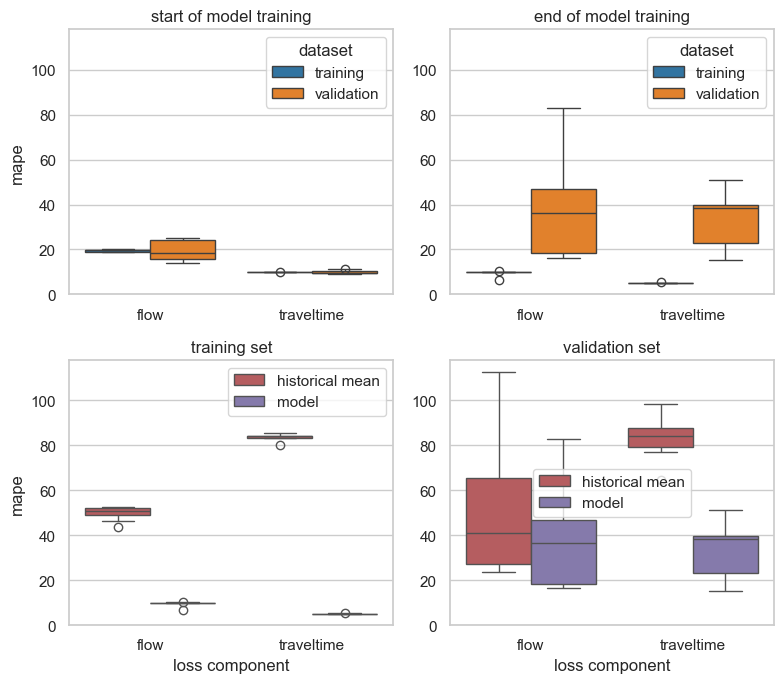

In [101]:
fig, axs = plot_metrics_kfold(df = metrics_kfold_df['tvodlulpe'][metrics_kfold_df['tvodlulpe'].component.isin(['flow','traveltime'])], metric_name = 'mape', showfliers = True)

for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)

plt.savefig('output/figures/results/fresno-kfold-mape-tvodlulpe.png')

plt.show()

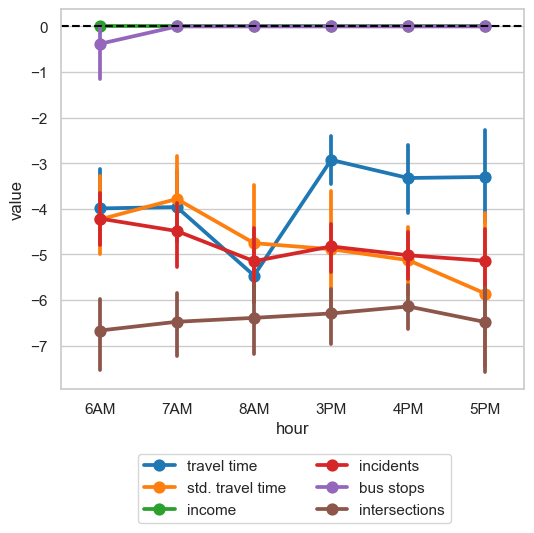

In [102]:
parameters_kfold_df['tvodlulpe']['hour'] = parameters_kfold_df['tvodlulpe'].period.replace({v: k for k, v in models_kfold['tvodlulpe'].period_dict.items()}). \
    replace(dict(zip(period_keys.period_id, period_keys.hour)))

parameters_kfold_df['tvodlulpe']['parameter'] = parameters_kfold_df['tvodlulpe']['parameter'].\
    replace({'tt': 'travel time', 'median_inc': 'income', 'tt_sd': 'std. travel time', 'bus_stops': 'bus stops', 'vot': 'reliability ratio'})

parameters_kfold_df['tvodlulpe']['hour'] \
    = parameters_kfold_df['tvodlulpe']['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models_kfold['tvodlulpe'].period_dict.items()})

parameters_kfold_df['tvodlulpe'] = parameters_kfold_df['tvodlulpe'][parameters_kfold_df['tvodlulpe'].parameter != 'reliability ratio']

fig, axs = plot_parameters_kfold(df = parameters_kfold_df['tvodlulpe'][parameters_kfold_df['tvodlulpe'].group == 'utility'], n_cols_legend = 2, figsize = (5.5,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-kfold-utility-periods-tvodlulpe.png')

plt.show()

### - TVGODLULPE

In [103]:
n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

In [104]:
models_kfold['tvgodlulpe'], _ = create_model(
    n_periods = n_periods,
    network = network,
    performance_function = create_mlp(network = network,
                                      poly_order = 4, pretrain = False, link_specific = False),
    historic_g= generated_trips,
    generation = True,
    generation_trainable = True,
    utility_trainable = True)

models_kfold['tvgodlulpe'].build()

# Prevent to repretrain generation weights
models_kfold['tvgodlulpe'].generation._pretrain_generation_weights = False

In [105]:
# Use pretrained weights
models_kfold['tvgodlulpe'].load_weights(models['tvgodlulpe']._filepath_weights)

In [106]:
# Assumed there is access to reference OD matrix
q_reference = models_kfold['tvgodlulpe'].q

q_reference

<tf.Tensor: shape=(6, 6970), dtype=float32, numpy=
array([[0.2013, 0.701 , 0.5531, ..., 0.0123, 0.0125, 0.0078],
       [0.1165, 0.554 , 0.4507, ..., 0.022 , 0.0225, 0.0157],
       [0.1779, 0.4502, 0.3001, ..., 0.0136, 0.0136, 0.0124],
       [0.1254, 0.173 , 0.3648, ..., 0.0049, 0.005 , 0.0056],
       [0.082 , 0.1387, 0.2756, ..., 0.0075, 0.0075, 0.0093],
       [0.0789, 0.0985, 0.4618, ..., 0.009 , 0.0091, 0.0088]],
      dtype=float32)>

In [107]:
# Add historic OD from estimation in 2019
models_kfold['tvgodlulpe'].od.historic_values = q_reference

In [108]:
# Add deviation respect to historic OD matrix for better generalization.
_LOSS_WEIGHTS_KFOLD ={'od': 1, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

In [ ]:
metrics_kfold_df['tvgodlulpe'], parameters_kfold_df['tvgodlulpe'] = train_kfold(
    n_splits=10,
    random_state = _SEED,
    model = models_kfold['tvgodlulpe'],
    X = XT_val, Y = YT_val,
    optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
                 'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
                 },
    node_data = nodes_df,
    loss_weights=_LOSS_WEIGHTS_KFOLD,
    loss_metric=_LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    pretrain_link_flows = False,
    # threshold_relative_gap= 5e-2,
    threshold_relative_gap= _RELATIVE_GAP,
    batch_size=_BATCH_SIZE,
    epochs = _EPOCHS,
)


Fold 1/10

Model training
Benchmark metrics using historical mean in training data to make predictions in the validation set: 


    component   value metric
0        flow      25   mape
1  traveltime      83   mape
0        flow 6.1e+05    mse
1  traveltime   0.051    mse
0        flow   -0.15     r2
1  traveltime -0.0018     r2

hyperparameters loss function: {'od': 1, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

number of periods: 6, batch size: 1, threshold relative gap: 0.05
training set -> timepoints: 78, obs [t x]: [1303.  125.], coverage [t x]: [0.54 0.05]
validation set -> timepoints: 78, obs [t x]: [139.  15.], coverage [t x]: [0.06 0.01]

Learning stage: 30 epochs

0/60: train mse=4.9e+04, train mse traveltime=0.0077, train mape traveltime=12.3 train mse flow=1.4e+05, train mape flow=19.4, val mse=4.4e+04, val mse traveltime=0.006, val mape traveltime=11.6 val mse flow=1.2e+05, val mape flow=14.9, theta = [-2.691 -3.132  0.    -5.695  0.    -4.562], avg rr = 1.16, avg the

In [ ]:
filename = f"{ts}_kfold_{network.key}.csv"
metrics_kfold_df['tvgodlulpe'].to_csv(f"./output/experiments/{filename}")
print(f"File {filename} written with k-fold results for TVGODULPE model")


# TODO: Add coefficient of variation and save experiments results, compute percentage reduction between final and initial
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(metrics_kfold_df['tvgodlulpe'][metrics_kfold_df['tvgodlulpe'].component.isin(['flow','traveltime'])].\
          groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
          aggregate(['median', 'mean', 'std']))

In [ ]:
fig, axs = plot_metrics_kfold(df = metrics_kfold_df['tvgodlulpe'][metrics_kfold_df['tvgodlulpe'].component.isin(['flow','traveltime'])], metric_name = 'mape', showfliers = True)

for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)

plt.savefig('output/figures/results/fresno-kfold-mape-tvgodlulpe.png')

plt.show()

In [ ]:
parameters_kfold_df['tvgodlulpe']['hour'] = parameters_kfold_df['tvgodlulpe'].period.replace({v: k for k, v in models_kfold['tvgodlulpe'].period_dict.items()}). \
    replace(dict(zip(period_keys.period_id, period_keys.hour)))

parameters_kfold_df['tvgodlulpe']['parameter'] = parameters_kfold_df['tvgodlulpe']['parameter'].\
    replace({'tt': 'travel time', 'median_inc': 'income', 'tt_sd': 'std. travel time', 'bus_stops': 'bus stops', 'vot': 'reliability ratio'})

parameters_kfold_df['tvgodlulpe']['hour'] \
    = parameters_kfold_df['tvgodlulpe']['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models_kfold['tvgodlulpe'].period_dict.items()})

parameters_kfold_df['tvgodlulpe'] = parameters_kfold_df['tvgodlulpe'][parameters_kfold_df['tvgodlulpe'].parameter != 'reliability ratio']

fig, axs = plot_parameters_kfold(df = parameters_kfold_df['tvgodlulpe'][parameters_kfold_df['tvgodlulpe'].group == 'utility'], n_cols_legend = 2, figsize = (5.5,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-kfold-utility-periods-tvgodlulpe.png')

plt.show()

fig, axs = plot_parameters_kfold(df = parameters_kfold_df['tvgodlulpe'][parameters_kfold_df['tvgodlulpe'].group == 'generation'], n_cols_legend = 3, figsize = (5.5,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-kfold-generation-periods-tvgodlulpe.png')

plt.show()

### Comparison between our model and benchmarks

In [ ]:
metrics_kfold_plot_df = metrics_kfold_df['tvgodlulpe'][
        (metrics_kfold_df['tvgodlulpe'].component != 'equilibrium') & (metrics_kfold_df['tvgodlulpe'].metric == 'mape') &
        (metrics_kfold_df['tvgodlulpe'].dataset == 'validation') & (metrics_kfold_df['tvgodlulpe'].stage == 'final')].\
        assign(model = 'tvgodlulpe')

In [ ]:
metrics_kfold_df['baselines'] \
    = metrics_kfold_df['baselines'].groupby(['fold', 'model', 'component'])[['value']].mean().reset_index()

metrics_kfold_plot_df = pd.concat([metrics_kfold_df['baselines'][['model','component','value']],
                                   metrics_kfold_plot_df[['model','component','value']]])

In [ ]:
means_mapes = metrics_kfold_plot_df.groupby(['component','model'])['value'].mean().reset_index().rename(columns={'value':'mean'})
se_mapes = metrics_kfold_plot_df.groupby(['component','model'])['value'].agg(['std', 'count']).apply(lambda row: row['std'] / np.sqrt(row['count']), axis=1).reset_index().rename(columns={0:'se'})

pd.merge(means_mapes, se_mapes).sort_values(by = ['component', 'mean'])

In [ ]:
# Note: Result from ordinary kriging are removed due to unstable estimates and extremely large values of MAPE for travel time
plot_baselines_kfold(df = metrics_kfold_plot_df[metrics_kfold_plot_df.model != 'ordinary_kriging'],
                     metric_name='mape', sharex=True, sharey=True, showfliers = False)

plt.show()

In [ ]:
# Link-level spatial information
links_gdf['link_key'] = pd.Categorical(links_gdf['key'].apply(ast.literal_eval), list(network.links_dict.keys()))

# Create dataframe with data collected in 2020 during peak hours only
model_df = df[(df.hour.isin([6,7,8, 15,16,17])) & (df['year']==2020)].sort_values(['period','link_key'])
# links_gdf = links_gdf.sort_values(['link_key'])

# Build dataset witg data collected between 4-5pm in the first Tuesdays of Oct 2019 and 2020
benchmark_df = df[(df.hour == 16) & df['date'].isin(['2019-10-01', '2020-10-06'])].sort_values(['period','link_key'])

fig_speed, fig_flow, legend = plot_congestion_maps(model=inference_model, model_df=model_df, benchmark_df = benchmark_df,
                     gdf=links_gdf.sort_values(['link_key']), features=_FEATURES_Z, cmap = 'viridis')

In [ ]:
# Link-level spatial information
links_gdf['link_key'] = pd.Categorical(links_gdf['key'].apply(ast.literal_eval), list(network.links_dict.keys()))

# Create dataframe with data collected in 2020 during peak hours only
model_df = df[(df.hour.isin([6,7,8, 15,16,17])) & (df['year']==2020)].sort_values(['period','link_key'])
# links_gdf = links_gdf.sort_values(['link_key'])

# Build dataset witg data collected between 4-5pm in the first Tuesdays of Oct 2019 and 2020
benchmark_df = df[(df.hour == 16) & df['date'].isin(['2019-10-01', '2020-10-06'])].sort_values(['period','link_key'])

fig_speed, fig_flow, legend = plot_congestion_maps(model=inference_model, model_df=model_df, benchmark_df = benchmark_df,
                     gdf=links_gdf.sort_values(['link_key']), features=_FEATURES_Z, cmap = 'viridis')

In [ ]:
fig_flow

In [ ]:
fig_speed

In [ ]:
legend

## Write estimation results

In [ ]:
train_results_df, val_results_df \
    = map(lambda x: pd.concat([results.assign(model = model)[['model'] + list(results.columns)]
                               for model, results in x.items()],axis = 0), [train_results_dfs, val_results_dfs])

train_filename = f"{ts}_train_results_{network.key}.csv"
val_filename = f"{ts}_validation_results_{network.key}.csv"
train_results_df.to_csv(f"./output/tables/{train_filename}")
print(f'File {train_filename} was written')
val_results_df.to_csv(f"./output/tables/{val_filename}")
print(f'File {val_filename} was written')

## Summary of parameter estimates

### All models

In [ ]:
models

In [ ]:
results = pd.DataFrame({'parameter': [], 'model': []})

for model_key, model in models.items():
    model_results = {**dict(zip(['tt'] + _FEATURES_Z, list(np.mean(model.theta.numpy(), axis=0)))),
                     **{'rr': float(model.get_parameters_estimates().eval('tt_sd/tt').iloc[0]),
                        'fixed_effect_mean': np.mean(model.fixed_effect),
                        'fixed_effect_std': np.std(model.fixed_effect),
                        'od_mean': np.mean(model.q),
                        'od_std': np.std(model.q)
                        }}

    if model.performance_function.type == 'bpr':
        model_results = {**model_results, **{'alpha_mean': np.mean(model.performance_function.alpha),
                                             'alpha_std': np.std(model.performance_function.alpha),
                                             'beta_mean': np.mean(model.performance_function.beta),
                                             'beta_std': np.std(model.performance_function.beta)}}

    model_results = pd.DataFrame({'parameter': model_results.keys(), 'values': model_results.values()}). \
        assign(model=model_key)

    results = pd.concat([results, model_results])

In [ ]:
print(results.pivot_table(index = ['parameter'], columns = 'model', values = 'values', sort=False).round(4))

### TVGODLULPE

In [ ]:
# Stats by period
model = models['tvgodlulpe']

with pd.option_context('display.float_format', '{:0.4f}'.format):
    print('theta:', pd.DataFrame(model.theta.numpy().T))

In [ ]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print('kappa:', pd.DataFrame(model.kappa.numpy().T))

In [ ]:
# with pd.option_context('display.float_format', '{:0.1f}'.format):
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print('OD matrix', pd.DataFrame({'od_mean': np.mean(model.q,axis = 1), 'od_std': np.std(model.q, axis = 1), 'od_total':np.sum(model.q,axis = 1)}).T)

## Summary of models goodness of fit

In [ ]:
results_losses = pd.DataFrame({})
loss_columns = ['loss_flow', 'loss_traveltime', 'loss_equilibrium', 'loss_total']

for model_key, model in models.items():
    results_losses_model = model.split_results(train_results_dfs[model_key])[1].assign(model=model_key)
    results_losses_model = results_losses_model[results_losses_model.epoch == _EPOCHS['learning']].iloc[[0]]
    results_losses = pd.concat([results_losses, results_losses_model])

results_losses[loss_columns] = (results_losses[loss_columns] - 1) * 100

In [ ]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print(results_losses[['model'] + list(results_losses.columns)])

## Plot of convergence toward true rr across models

In [ ]:
train_estimates = {}
train_losses = {}

for model_key, model in models.items():
    train_estimates[model_key], train_losses[model_key] = model.split_results(results=train_results_dfs[model_key])

    train_estimates[model_key]['model'] = model_key

train_estimates_df = pd.concat(train_estimates.values())

train_estimates_df['rr'] = train_estimates_df['tt_sd'] / train_estimates_df['tt']

estimates = train_estimates_df[['epoch', 'model', 'rr']].reset_index().drop('index', axis=1)
#estimates = estimates[estimates.epoch != 0]

fig, ax = plt.subplots(nrows=1, ncols=1)

g = sns.lineplot(data=estimates, x='epoch', hue='model', y='rr')

# ax.hlines(y=compute_rr(models.popitem().true_values), xmin=estimates['epoch'].min(), xmax=estimates['epoch'].max(), linestyle='--', label = 'truth')

ax.set_ylabel('reliability ratio')

ax.set_xticks(np.arange(estimates['epoch'].min(), estimates['epoch'].max() + 2, _XTICKS_SPACING))

#ax.set_yscale('log')
#plt.ylim(ymin=0)
plt.show()

## Plot of reliability ratio by hour for all models

In [ ]:
reliability_ratios = plot_rr_by_period_models(models, period_keys, period_feature='hour', join = True)

plt.savefig('output/figures/results/fresno-reliability-ratios-periods.png')

plt.show()

In [ ]:
print(reliability_ratios)

In [ ]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print(reliability_ratios[reliability_ratios.model == 'tvgodlulpe'][['hour','rr']].T)

In [ ]:
print(reliability_ratios.groupby('model')[['rr']].mean().round(4))

## Plot of total trips by hour for all models

In [ ]:
total_trips = plot_total_trips_models(models = models, period_feature = 'hour', period_keys = period_keys,
                                      historic_od = network.q.flatten(), join = True)

plt.savefig('output/figures/results/fresno-total-trips-periods.png')

plt.show()

In [ ]:
print(total_trips)

In [ ]:
total_trips.groupby('model')[['total_trips']].mean().round(1)

In [ ]:
total_trips.groupby('model')[['total_trips']].sum().round(1)



## Global runtime

In [ ]:
print(f'runtime: {time.time()-t0_global:0.1f} [s]')